In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [2]:
import pandas as pd

In [3]:
# Set batch size for training
BATCH_SIZE = 16

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 0.2

In [4]:
data = np.load("/kaggle/input/datasetcleaned/mars_for_students.npz")

In [5]:
X = np.load('/kaggle/input/datasetcleaned/X.npy')
y = np.load('/kaggle/input/datasetcleaned/y.npy')
X_test = data["test_set"]

In [6]:
import albumentations as A
aug = A.Compose(
    [
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=0.8)
    ]
)

In [7]:
for i in range(len(X)):
    if np.any(y[i] == 4):
        temp = aug(image = X[i], mask = y[i])
        temp_image = np.expand_dims(temp['image'], axis=0)  # Add a batch dimension
        temp_mask = np.expand_dims(temp['mask'], axis=0)    # Add a batch dimension

        
        X = np.concatenate((X, temp_image), axis=0)
        y = np.concatenate((y, temp_mask), axis=0)
        print(X.shape)



(2506, 64, 128)
(2507, 64, 128)
(2508, 64, 128)
(2509, 64, 128)
(2510, 64, 128)
(2511, 64, 128)
(2512, 64, 128)
(2513, 64, 128)
(2514, 64, 128)
(2515, 64, 128)
(2516, 64, 128)
(2517, 64, 128)
(2518, 64, 128)
(2519, 64, 128)
(2520, 64, 128)
(2521, 64, 128)
(2522, 64, 128)
(2523, 64, 128)
(2524, 64, 128)
(2525, 64, 128)
(2526, 64, 128)
(2527, 64, 128)
(2528, 64, 128)
(2529, 64, 128)
(2530, 64, 128)
(2531, 64, 128)
(2532, 64, 128)
(2533, 64, 128)
(2534, 64, 128)
(2535, 64, 128)
(2536, 64, 128)
(2537, 64, 128)
(2538, 64, 128)
(2539, 64, 128)
(2540, 64, 128)
(2541, 64, 128)
(2542, 64, 128)
(2543, 64, 128)
(2544, 64, 128)
(2545, 64, 128)
(2546, 64, 128)
(2547, 64, 128)
(2548, 64, 128)
(2549, 64, 128)
(2550, 64, 128)
(2551, 64, 128)
(2552, 64, 128)
(2553, 64, 128)
(2554, 64, 128)
(2555, 64, 128)
(2556, 64, 128)
(2557, 64, 128)
(2558, 64, 128)
(2559, 64, 128)
(2560, 64, 128)
(2561, 64, 128)
(2562, 64, 128)
(2563, 64, 128)
(2564, 64, 128)
(2565, 64, 128)
(2566, 64, 128)
(2567, 64, 128)
(2568, 6

In [8]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
X_train, X_val,y_train, y_val = train_test_split(
    X, y, test_size=SPLITS_SIZE, random_state=seed
)
X_train = (X_train[..., np.newaxis]) / 255.0
X_val = (X_val[..., np.newaxis]) / 255.0
X_test = (X_test[..., np.newaxis])/ 255.0
print("Data splitted!")
print("X_train:",X_train.shape,"y_train:",y_train.shape,"X_val:",X_val.shape,"y_val:",y_val.shape)
print(X_test.shape)

Splitting data...
Data splitted!
X_train: (2054, 64, 128, 1) y_train: (2054, 64, 128) X_val: (514, 64, 128, 1) y_val: (514, 64, 128)
(10022, 64, 128, 1)


In [9]:
print(X_test.shape)

(10022, 64, 128, 1)


In [10]:
#Compute and adjust class weights
cw =compute_class_weight(class_weight="balanced",classes=np.unique(y_train),y=y_train.flatten())
print(cw)
cw[0] = 0.0
print(cw)

[ 0.80921074  0.60725697  0.85744741  1.0654779  78.86189394]
[ 0.          0.60725697  0.85744741  1.0654779  78.86189394]


In [11]:
 category_map = {
        0: 0,  # Background
        1: 1,  # Soil
        2: 2,  # Bedrock
        3: 3,  # Sand
        4: 4}  # Big Rock
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of original categories: {len(category_map)}")
print(f"Number of classes after mapping: {NUM_CLASSES}")

Number of original categories: 5
Number of classes after mapping: 5


In [12]:
def load_single_image(image, label, input_size=(64, 128)):
    
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.int32)

    return image, label

In [13]:
def apply_category_mapping(label):
    
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [14]:
@tf.function
def random_flip(image, label, seed=None):
    
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [15]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [16]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (16, 64, 128, 1)
Labels shape: (16, 64, 128)
Labels dtype: <dtype: 'int32'>


In [17]:
def gate(e,d,filters):
    a = tfkl.Add()([e, d])
    x = tfkl.Conv2D(filters, kernel_size=1, padding='same')(a)
    x = tfkl.Activation(activation="sigmoid")(x)
    b = tfkl.Multiply()([x, e])
    out = tfkl.Add()([a, b])
    return x

In [18]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        residual = x  # Store the input as residual
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
        x = tfkl.GroupNormalization(groups=16)(x)
        x = tfkl.Activation(activation)(x)
    # Return the transformed tensor
    return x


def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32)
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64)
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck 
    bottleneck = unet_block(d2, 128)

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    x = unet_block(down_block_2, 128)
    u1 = gate(u1, x, 128)
    u1 = unet_block(u1, 64)

    u2 = tfkl.UpSampling2D()(u1)
    y = unet_block(down_block_1, 64)
    u2 = gate(u2, y, 64)
    u2 = unet_block(u2, 32)

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet_with_Attention')
    return model


In [19]:

model = get_unet_model(input_shape=input_shape, num_classes=NUM_CLASSES)
# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet_with_Attention"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ group_normalizat… │ (None, 64, 128, │        64 │ conv2d[0][0]   │   Y   │
│ (GroupNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 64, 128, │         0 │ group_normali… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │     9,248 │ activation[0]… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ group_normalizat… │ (None, 64, 128, │        64 │ conv2d_1[0][0] │   Y   │
│ (GroupNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 64, 128, │         0 │ group_normali… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ activation_1[… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ group_normalizat… │ (None, 32, 64,  │       128 │ conv2d_2[0][0] │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 32, 64,  │         0 │ group_normali… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 32, 64,  │    36,928 │ activation_2[… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ group_normalizat… │ (None, 32, 64,  │       128 │ conv2d_3[0][0] │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_3      │ (None, 32, 64,  │         0 │ group_normali… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ activation_3[… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ group_normalizat… │ (None, 16, 32,  │       256 │ conv2d_4[0][0] │   Y 

 Total params: 724,613 (2.76 MB)

 Trainable params: 724,613 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def create_segmentation_colormap(num_classes):
    
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [21]:
import tensorflow.keras.backend as K

def focal_lossw(alpha=0.25, gamma=2.0, class_weights=None):
    def loss(y_true, y_pred):
        # Ensure y_true is one-hot encoded if not already
        if len(y_true.shape) != len(y_pred.shape):
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())

        # Compute cross-entropy loss
        ce_loss = -y_true * tf.math.log(y_pred)

        # Compute the focal loss scaling factor
        scaling_factor = tf.pow(1 - y_pred, gamma)

        # Apply the focal loss formula
        focal_loss = alpha * scaling_factor * ce_loss

        # Apply class weights if provided
        if class_weights is not None:
            # Convert class weights to tensor
            class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
            # Multiply the loss for each class by its weight
            focal_loss *= tf.expand_dims(tf.reduce_sum(y_true * class_weights_tensor, axis=-1), axis=-1)

        # Reduce the loss across spatial and class dimensions
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    return loss

focal = focal_lossw(alpha=0.25, gamma=2.0,class_weights=cw)
# Compile the model
print("Compiling model...")
model.compile(
    loss=focal,
    optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,    # Adjust based on your dataset and model
    weight_decay=1e-3      # High decay to regularize small batches
),
    metrics=[MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_val[0], y_val[0])

#Implement Learning Rate Reducing
lr_callback = ReduceLROnPlateau(
    monitor='val_mean_iou',  # Metric to monitor
    mode = 'max',
    factor=0.5,          # Reduce LR by 50%
    patience=10,          # Wait 10 epochs of no improvement
    verbose=1,           # Print updates
    min_lr=1e-6          # Lower bound on LR
)

Epoch 1/1000


I0000 00:00:1734198406.281756      92 service.cc:145] XLA service 0x7fbfa4034770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734198406.281827      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734198406.281834      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/129 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.2499 - mean_iou: 0.0301   

I0000 00:00:1734198425.517143      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1791 - mean_iou: 0.1063

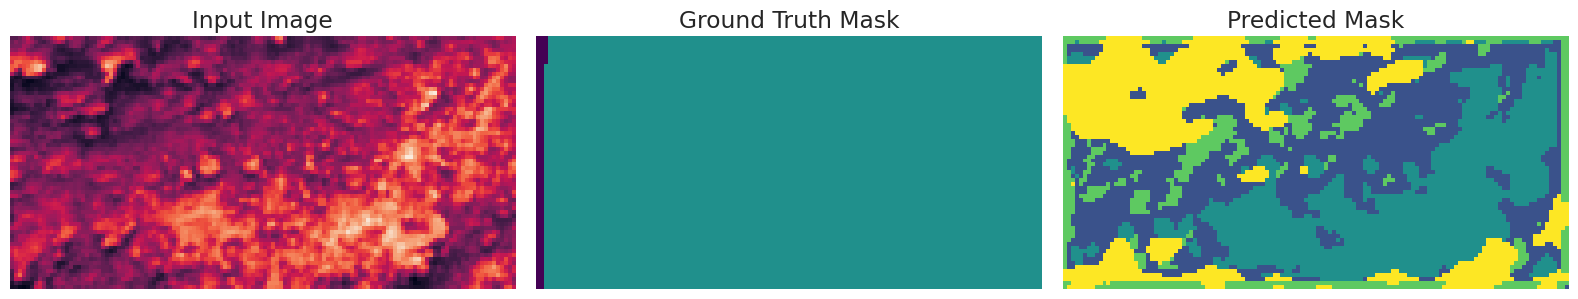

129/129 ━━━━━━━━━━━━━━━━━━━━ 59s 231ms/step - loss: 0.1789 - mean_iou: 0.1063 - val_loss: 0.1394 - val_mean_iou: 0.1797 - learning_rate: 0.0010
Epoch 2/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.1438 - mean_iou: 0.1650 - val_loss: 0.1366 - val_mean_iou: 0.2007 - learning_rate: 0.0010
Epoch 3/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.1330 - mean_iou: 0.1739 - val_loss: 0.1313 - val_mean_iou: 0.2355 - learning_rate: 0.0010
Epoch 4/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.1271 - mean_iou: 0.1987 - val_loss: 0.1223 - val_mean_iou: 0.2452 - learning_rate: 0.0010
Epoch 5/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.1179 - mean_iou: 0.2139 - val_loss: 0.1088 - val_mean_iou: 0.2493 - learning_rate: 0.0010
Epoch 6/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1094 - mean_iou: 0.2191

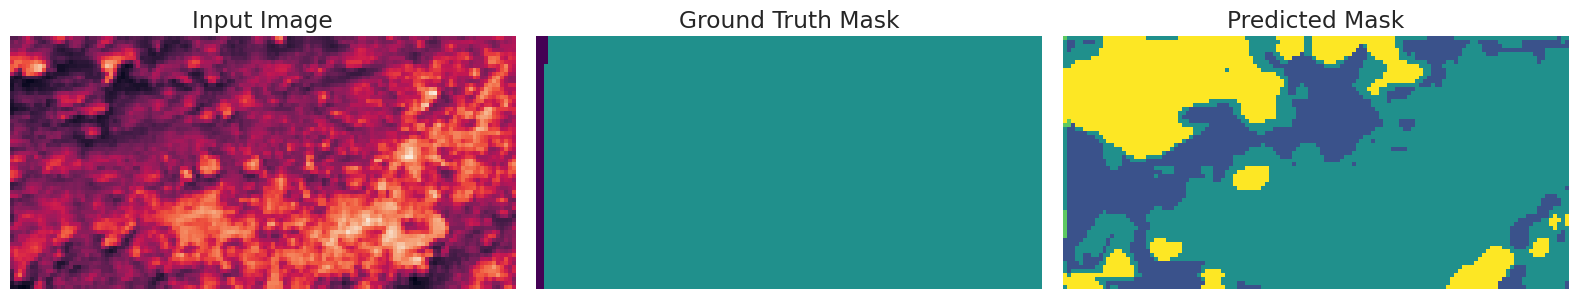

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.1094 - mean_iou: 0.2191 - val_loss: 0.1061 - val_mean_iou: 0.2444 - learning_rate: 0.0010
Epoch 7/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1094 - mean_iou: 0.2257 - val_loss: 0.1014 - val_mean_iou: 0.2546 - learning_rate: 0.0010
Epoch 8/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1033 - mean_iou: 0.2333 - val_loss: 0.0988 - val_mean_iou: 0.2635 - learning_rate: 0.0010
Epoch 9/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0998 - mean_iou: 0.2486 - val_loss: 0.1021 - val_mean_iou: 0.2745 - learning_rate: 0.0010
Epoch 10/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.1010 - mean_iou: 0.2561 - val_loss: 0.0880 - val_mean_iou: 0.2584 - learning_rate: 0.0010
Epoch 11/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0915 - mean_iou: 0.2871

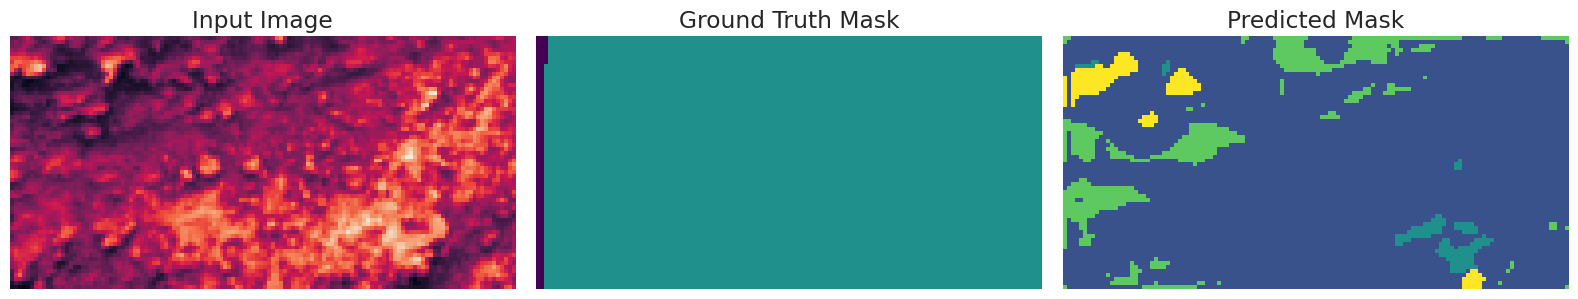

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0914 - mean_iou: 0.2872 - val_loss: 0.0868 - val_mean_iou: 0.2602 - learning_rate: 0.0010
Epoch 12/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0957 - mean_iou: 0.2629 - val_loss: 0.0916 - val_mean_iou: 0.2683 - learning_rate: 0.0010
Epoch 13/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0917 - mean_iou: 0.2844 - val_loss: 0.0822 - val_mean_iou: 0.2973 - learning_rate: 0.0010
Epoch 14/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0859 - mean_iou: 0.3058 - val_loss: 0.0781 - val_mean_iou: 0.3136 - learning_rate: 0.0010
Epoch 15/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0834 - mean_iou: 0.3255 - val_loss: 0.0791 - val_mean_iou: 0.3318 - learning_rate: 0.0010
Epoch 16/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0821 - mean_iou: 0.3160

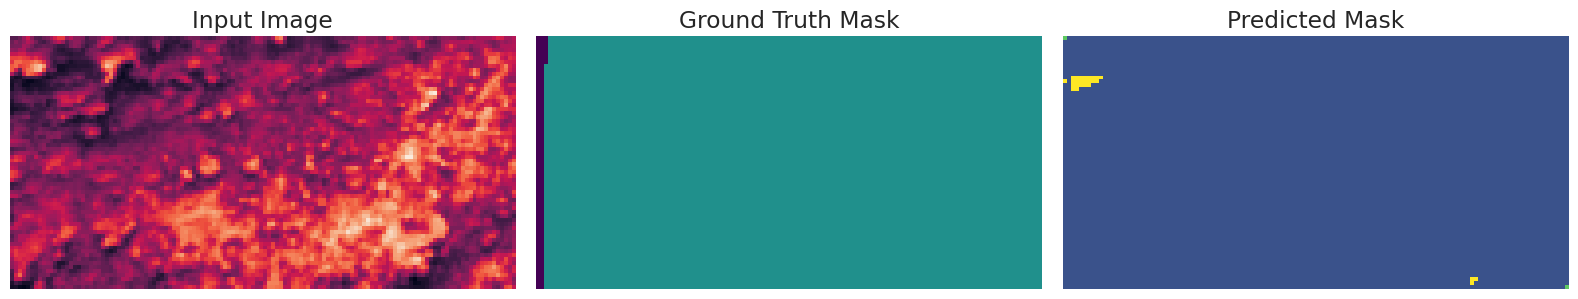

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0821 - mean_iou: 0.3161 - val_loss: 0.0774 - val_mean_iou: 0.3271 - learning_rate: 0.0010
Epoch 17/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0748 - mean_iou: 0.3576 - val_loss: 0.0713 - val_mean_iou: 0.3525 - learning_rate: 0.0010
Epoch 18/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0758 - mean_iou: 0.3572 - val_loss: 0.0725 - val_mean_iou: 0.3389 - learning_rate: 0.0010
Epoch 19/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0783 - mean_iou: 0.3351 - val_loss: 0.0723 - val_mean_iou: 0.3280 - learning_rate: 0.0010
Epoch 20/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0707 - mean_iou: 0.3696 - val_loss: 0.0681 - val_mean_iou: 0.3809 - learning_rate: 0.0010
Epoch 21/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0665 - mean_iou: 0.3851

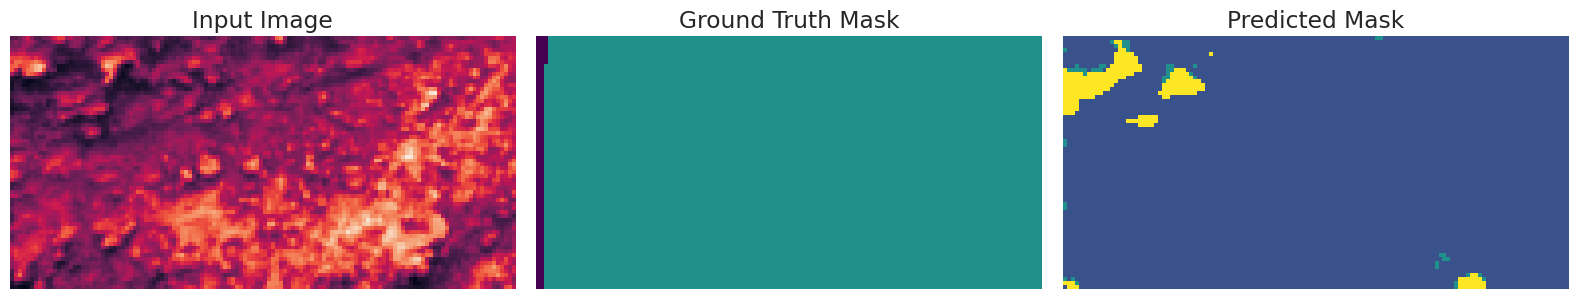

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0665 - mean_iou: 0.3852 - val_loss: 0.0669 - val_mean_iou: 0.3720 - learning_rate: 0.0010
Epoch 22/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0677 - mean_iou: 0.3887 - val_loss: 0.0641 - val_mean_iou: 0.3881 - learning_rate: 0.0010
Epoch 23/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0699 - mean_iou: 0.3813 - val_loss: 0.0665 - val_mean_iou: 0.4078 - learning_rate: 0.0010
Epoch 24/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0602 - mean_iou: 0.4128 - val_loss: 0.0674 - val_mean_iou: 0.4141 - learning_rate: 0.0010
Epoch 25/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0613 - mean_iou: 0.4192 - val_loss: 0.0684 - val_mean_iou: 0.4005 - learning_rate: 0.0010
Epoch 26/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0579 - mean_iou: 0.4372

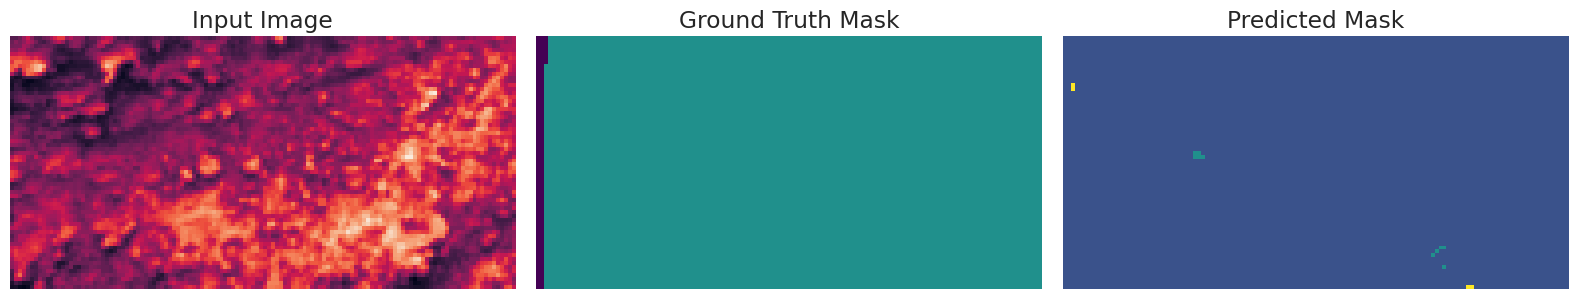

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0578 - mean_iou: 0.4373 - val_loss: 0.0639 - val_mean_iou: 0.4172 - learning_rate: 0.0010
Epoch 27/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0557 - mean_iou: 0.4431 - val_loss: 0.0604 - val_mean_iou: 0.4341 - learning_rate: 0.0010
Epoch 28/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0606 - mean_iou: 0.4256 - val_loss: 0.0658 - val_mean_iou: 0.4217 - learning_rate: 0.0010
Epoch 29/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0535 - mean_iou: 0.4551 - val_loss: 0.0607 - val_mean_iou: 0.4417 - learning_rate: 0.0010
Epoch 30/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0503 - mean_iou: 0.4684 - val_loss: 0.0595 - val_mean_iou: 0.4174 - learning_rate: 0.0010
Epoch 31/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0609 - mean_iou: 0.4196

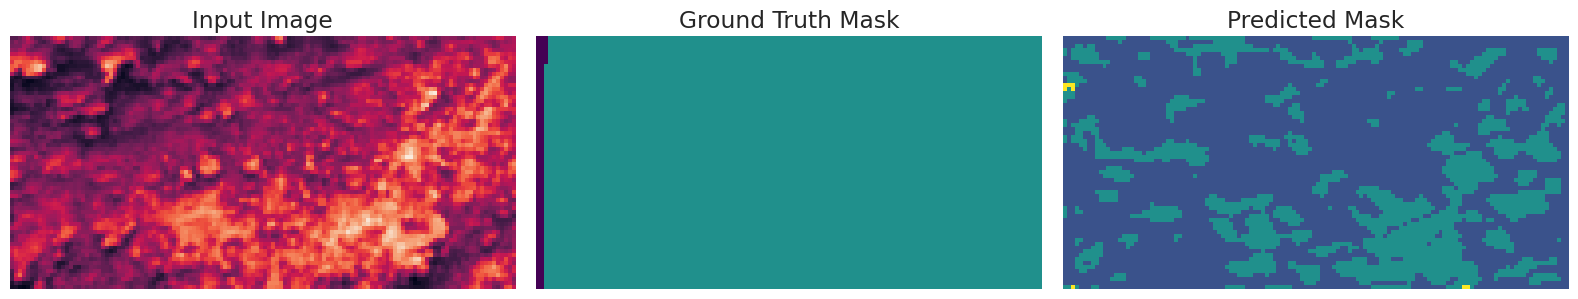

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0608 - mean_iou: 0.4200 - val_loss: 0.0580 - val_mean_iou: 0.4594 - learning_rate: 0.0010
Epoch 32/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0465 - mean_iou: 0.4944 - val_loss: 0.0591 - val_mean_iou: 0.4618 - learning_rate: 0.0010
Epoch 33/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0489 - mean_iou: 0.4918 - val_loss: 0.0549 - val_mean_iou: 0.4958 - learning_rate: 0.0010
Epoch 34/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0445 - mean_iou: 0.5097 - val_loss: 0.0576 - val_mean_iou: 0.4659 - learning_rate: 0.0010
Epoch 35/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0456 - mean_iou: 0.4993 - val_loss: 0.0548 - val_mean_iou: 0.4860 - learning_rate: 0.0010
Epoch 36/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0459 - mean_iou: 0.4987

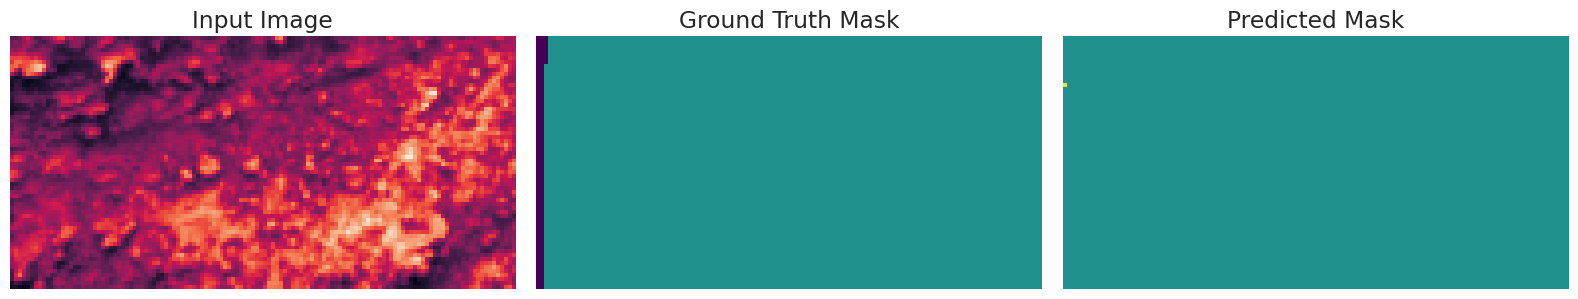

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0459 - mean_iou: 0.4988 - val_loss: 0.0576 - val_mean_iou: 0.4908 - learning_rate: 0.0010
Epoch 37/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0452 - mean_iou: 0.4956 - val_loss: 0.0580 - val_mean_iou: 0.4718 - learning_rate: 0.0010
Epoch 38/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0509 - mean_iou: 0.4745 - val_loss: 0.0534 - val_mean_iou: 0.4865 - learning_rate: 0.0010
Epoch 39/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0433 - mean_iou: 0.5026 - val_loss: 0.0541 - val_mean_iou: 0.4823 - learning_rate: 0.0010
Epoch 40/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0418 - mean_iou: 0.5165 - val_loss: 0.0587 - val_mean_iou: 0.4429 - learning_rate: 0.0010
Epoch 41/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0418 - mean_iou: 0.5018

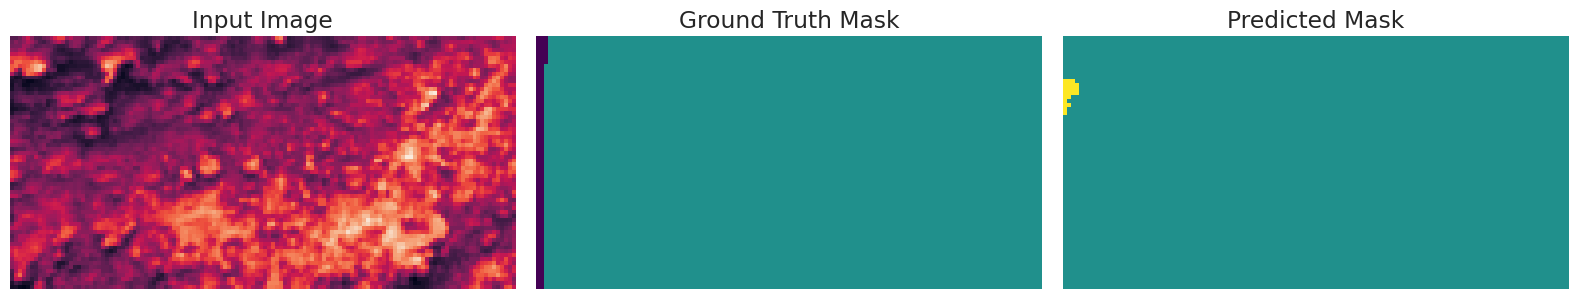

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0418 - mean_iou: 0.5019 - val_loss: 0.0515 - val_mean_iou: 0.4804 - learning_rate: 0.0010
Epoch 42/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0414 - mean_iou: 0.5040 - val_loss: 0.0496 - val_mean_iou: 0.5293 - learning_rate: 0.0010
Epoch 43/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0480 - mean_iou: 0.4869 - val_loss: 0.0635 - val_mean_iou: 0.5115 - learning_rate: 0.0010
Epoch 44/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0425 - mean_iou: 0.5136 - val_loss: 0.0498 - val_mean_iou: 0.5037 - learning_rate: 0.0010
Epoch 45/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0395 - mean_iou: 0.5215 - val_loss: 0.0513 - val_mean_iou: 0.5226 - learning_rate: 0.0010
Epoch 46/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0360 - mean_iou: 0.5383

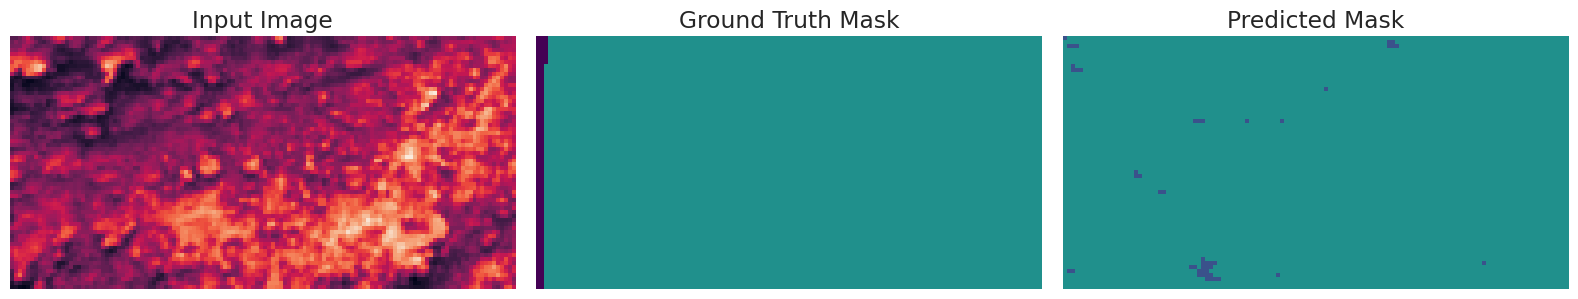

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0360 - mean_iou: 0.5382 - val_loss: 0.0476 - val_mean_iou: 0.5180 - learning_rate: 0.0010
Epoch 47/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0353 - mean_iou: 0.5342 - val_loss: 0.0479 - val_mean_iou: 0.5189 - learning_rate: 0.0010
Epoch 48/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0364 - mean_iou: 0.5389 - val_loss: 0.0502 - val_mean_iou: 0.5412 - learning_rate: 0.0010
Epoch 49/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0373 - mean_iou: 0.5316 - val_loss: 0.0580 - val_mean_iou: 0.5287 - learning_rate: 0.0010
Epoch 50/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0339 - mean_iou: 0.5495 - val_loss: 0.0543 - val_mean_iou: 0.5163 - learning_rate: 0.0010
Epoch 51/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0336 - mean_iou: 0.5457

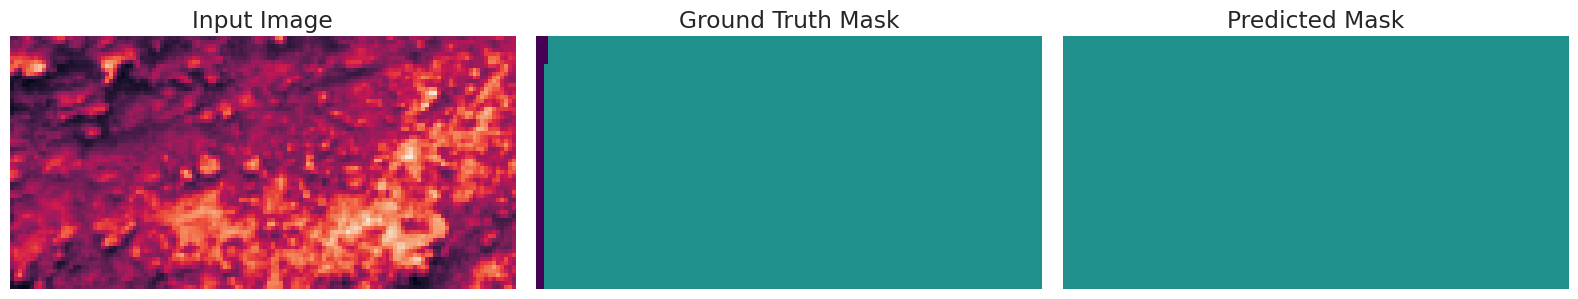

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0336 - mean_iou: 0.5457 - val_loss: 0.0553 - val_mean_iou: 0.5335 - learning_rate: 0.0010
Epoch 52/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0319 - mean_iou: 0.5521 - val_loss: 0.0481 - val_mean_iou: 0.5479 - learning_rate: 0.0010
Epoch 53/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0399 - mean_iou: 0.5116 - val_loss: 0.0458 - val_mean_iou: 0.5128 - learning_rate: 0.0010
Epoch 54/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0347 - mean_iou: 0.5330 - val_loss: 0.0467 - val_mean_iou: 0.5015 - learning_rate: 0.0010
Epoch 55/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0328 - mean_iou: 0.5454 - val_loss: 0.0464 - val_mean_iou: 0.5373 - learning_rate: 0.0010
Epoch 56/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0314 - mean_iou: 0.5617

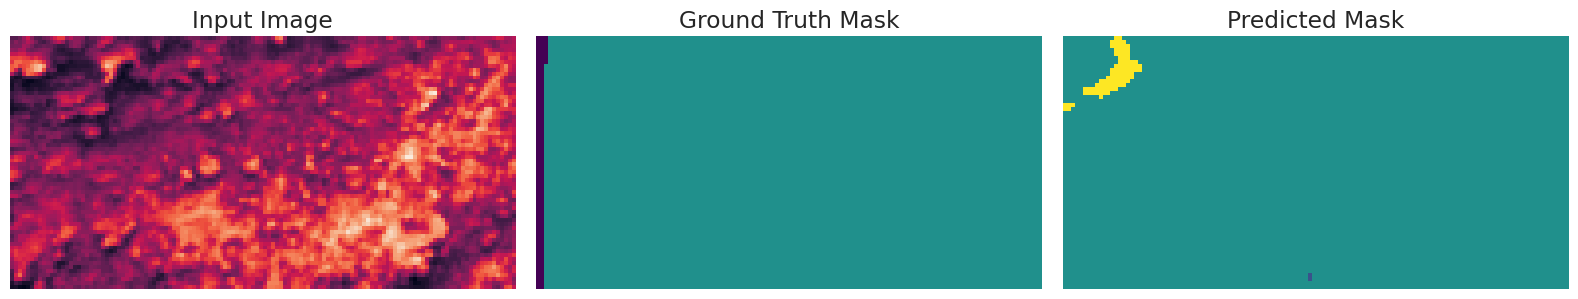

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0314 - mean_iou: 0.5617 - val_loss: 0.0441 - val_mean_iou: 0.4773 - learning_rate: 0.0010
Epoch 57/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0347 - mean_iou: 0.5288 - val_loss: 0.0551 - val_mean_iou: 0.5568 - learning_rate: 0.0010
Epoch 58/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0284 - mean_iou: 0.5775 - val_loss: 0.0579 - val_mean_iou: 0.5238 - learning_rate: 0.0010
Epoch 59/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0325 - mean_iou: 0.5603 - val_loss: 0.0493 - val_mean_iou: 0.5610 - learning_rate: 0.0010
Epoch 60/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0276 - mean_iou: 0.5751 - val_loss: 0.0432 - val_mean_iou: 0.5265 - learning_rate: 0.0010
Epoch 61/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0285 - mean_iou: 0.5633

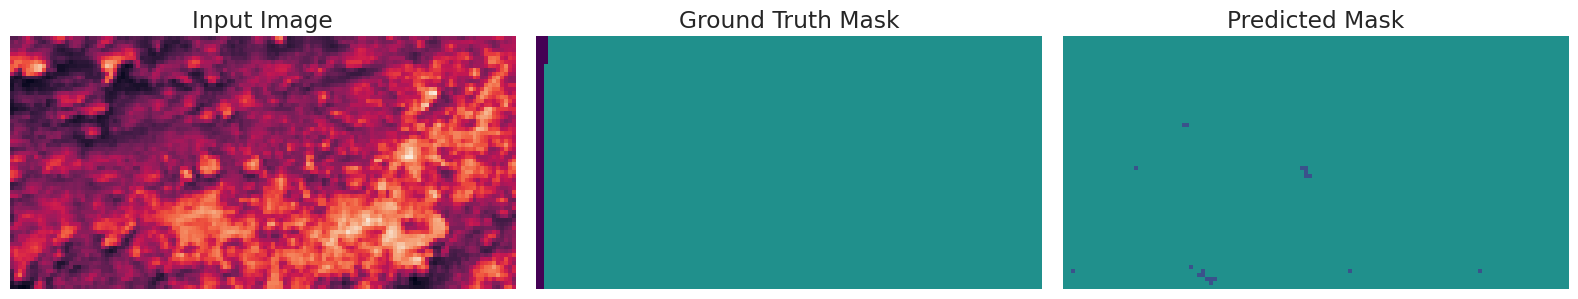

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0285 - mean_iou: 0.5634 - val_loss: 0.0493 - val_mean_iou: 0.5614 - learning_rate: 0.0010
Epoch 62/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0295 - mean_iou: 0.5692 - val_loss: 0.0472 - val_mean_iou: 0.5355 - learning_rate: 0.0010
Epoch 63/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0286 - mean_iou: 0.5797 - val_loss: 0.0614 - val_mean_iou: 0.5472 - learning_rate: 0.0010
Epoch 64/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0339 - mean_iou: 0.5463 - val_loss: 0.0445 - val_mean_iou: 0.5117 - learning_rate: 0.0010
Epoch 65/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0319 - mean_iou: 0.5506 - val_loss: 0.0508 - val_mean_iou: 0.5572 - learning_rate: 0.0010
Epoch 66/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0267 - mean_iou: 0.5830

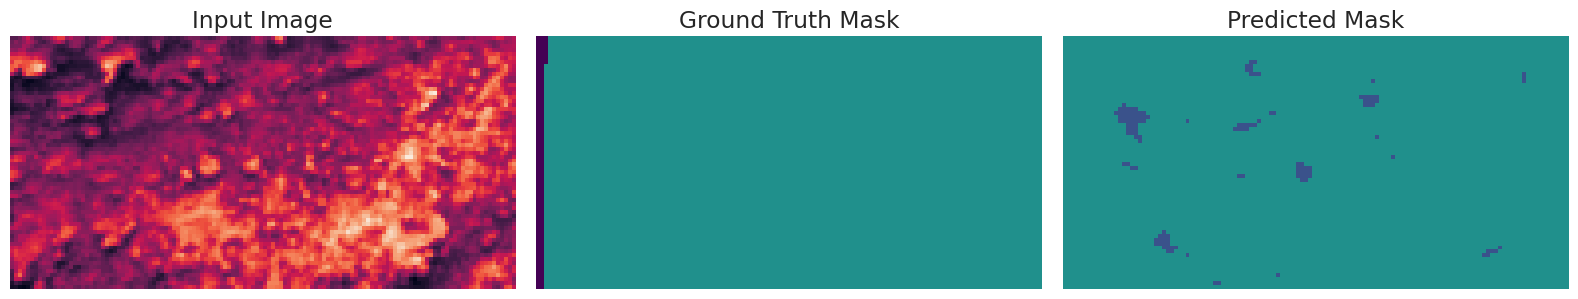

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0267 - mean_iou: 0.5832 - val_loss: 0.0494 - val_mean_iou: 0.5896 - learning_rate: 0.0010
Epoch 67/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0249 - mean_iou: 0.5933 - val_loss: 0.0422 - val_mean_iou: 0.5605 - learning_rate: 0.0010
Epoch 68/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0263 - mean_iou: 0.5840 - val_loss: 0.0457 - val_mean_iou: 0.5622 - learning_rate: 0.0010
Epoch 69/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0246 - mean_iou: 0.5965 - val_loss: 0.0572 - val_mean_iou: 0.5794 - learning_rate: 0.0010
Epoch 70/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0240 - mean_iou: 0.6016 - val_loss: 0.0525 - val_mean_iou: 0.5898 - learning_rate: 0.0010
Epoch 71/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0237 - mean_iou: 0.6049

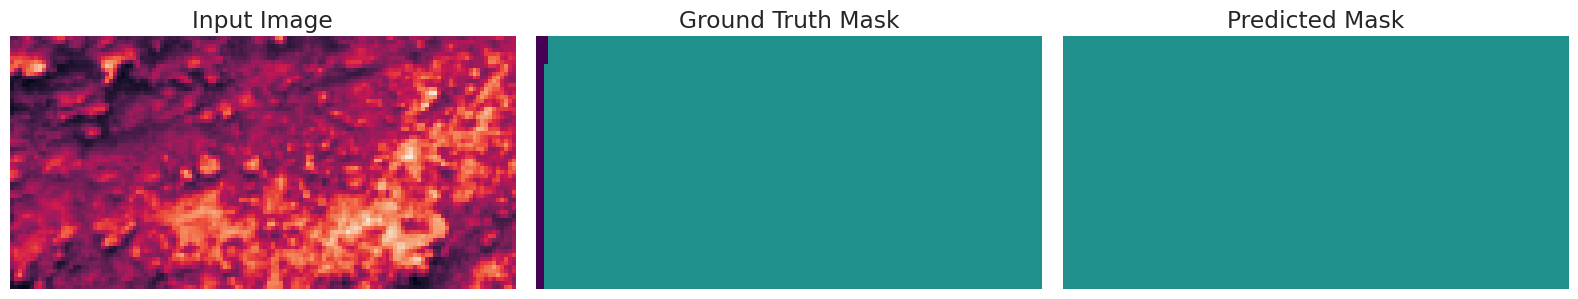

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0237 - mean_iou: 0.6047 - val_loss: 0.0416 - val_mean_iou: 0.5543 - learning_rate: 0.0010
Epoch 72/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0513 - mean_iou: 0.4917 - val_loss: 0.0482 - val_mean_iou: 0.4843 - learning_rate: 0.0010
Epoch 73/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0362 - mean_iou: 0.5426 - val_loss: 0.0374 - val_mean_iou: 0.5523 - learning_rate: 0.0010
Epoch 74/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0270 - mean_iou: 0.5860 - val_loss: 0.0388 - val_mean_iou: 0.5445 - learning_rate: 0.0010
Epoch 75/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0276 - mean_iou: 0.5719 - val_loss: 0.0444 - val_mean_iou: 0.5584 - learning_rate: 0.0010
Epoch 76/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0250 - mean_iou: 0.5943

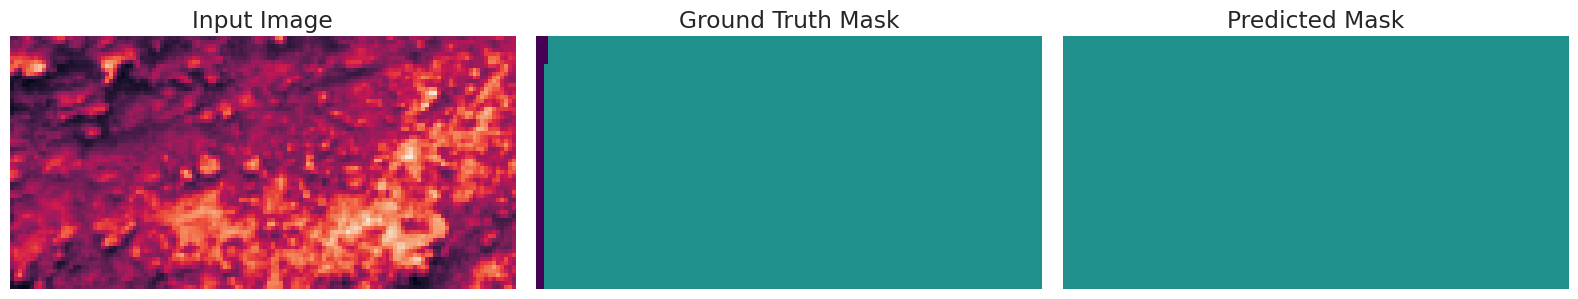

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0250 - mean_iou: 0.5941 - val_loss: 0.0402 - val_mean_iou: 0.5375 - learning_rate: 0.0010
Epoch 77/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0269 - mean_iou: 0.5759 - val_loss: 0.0408 - val_mean_iou: 0.5554 - learning_rate: 0.0010
Epoch 78/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0226 - mean_iou: 0.6058 - val_loss: 0.0394 - val_mean_iou: 0.5543 - learning_rate: 0.0010
Epoch 79/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0307 - mean_iou: 0.5543 - val_loss: 0.0418 - val_mean_iou: 0.5664 - learning_rate: 0.0010
Epoch 80/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0226 - mean_iou: 0.6078
Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0226 - mean_iou: 0.6080 - val_loss: 0.0444 - val_mean_iou: 0.5867 - learning_rate: 0.0010
Epoch 81/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0198 - mean_iou

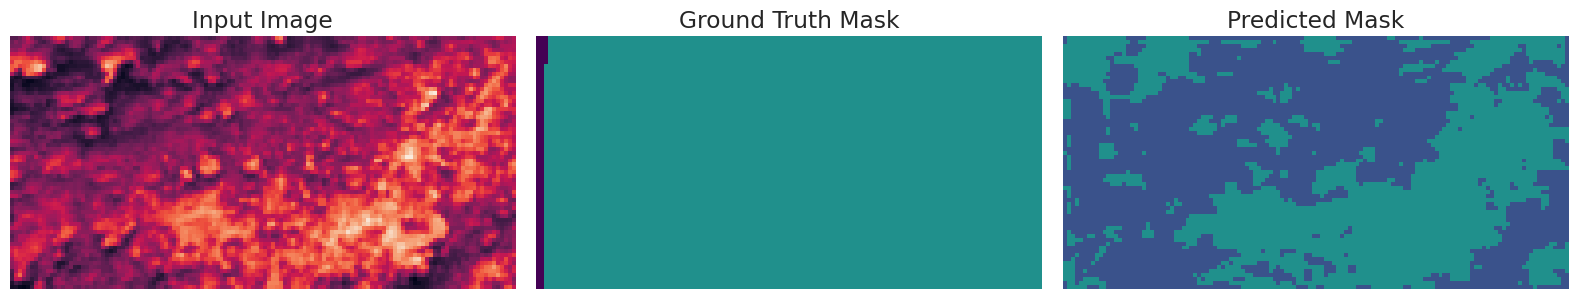

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0198 - mean_iou: 0.6329 - val_loss: 0.0370 - val_mean_iou: 0.5910 - learning_rate: 5.0000e-04
Epoch 82/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0184 - mean_iou: 0.6459 - val_loss: 0.0365 - val_mean_iou: 0.5921 - learning_rate: 5.0000e-04
Epoch 83/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0187 - mean_iou: 0.6413 - val_loss: 0.0394 - val_mean_iou: 0.5912 - learning_rate: 5.0000e-04
Epoch 84/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0179 - mean_iou: 0.6499 - val_loss: 0.0409 - val_mean_iou: 0.5896 - learning_rate: 5.0000e-04
Epoch 85/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0179 - mean_iou: 0.6497 - val_loss: 0.0411 - val_mean_iou: 0.5988 - learning_rate: 5.0000e-04
Epoch 86/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0174 - mean_iou: 0.6553

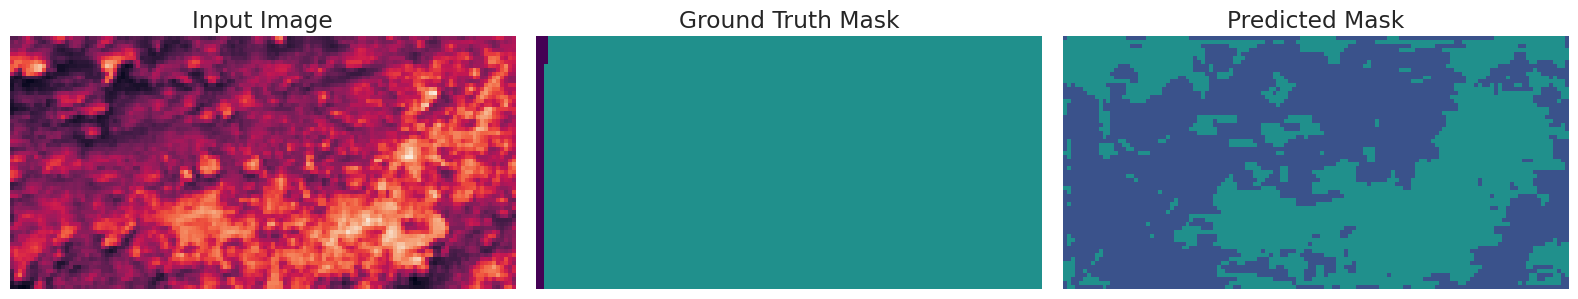

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0174 - mean_iou: 0.6554 - val_loss: 0.0416 - val_mean_iou: 0.5954 - learning_rate: 5.0000e-04
Epoch 87/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0169 - mean_iou: 0.6613 - val_loss: 0.0398 - val_mean_iou: 0.5870 - learning_rate: 5.0000e-04
Epoch 88/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0172 - mean_iou: 0.6562 - val_loss: 0.0420 - val_mean_iou: 0.5943 - learning_rate: 5.0000e-04
Epoch 89/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0169 - mean_iou: 0.6618 - val_loss: 0.0467 - val_mean_iou: 0.6034 - learning_rate: 5.0000e-04
Epoch 90/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0163 - mean_iou: 0.6708 - val_loss: 0.0450 - val_mean_iou: 0.5944 - learning_rate: 5.0000e-04
Epoch 91/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0170 - mean_iou: 0.6584

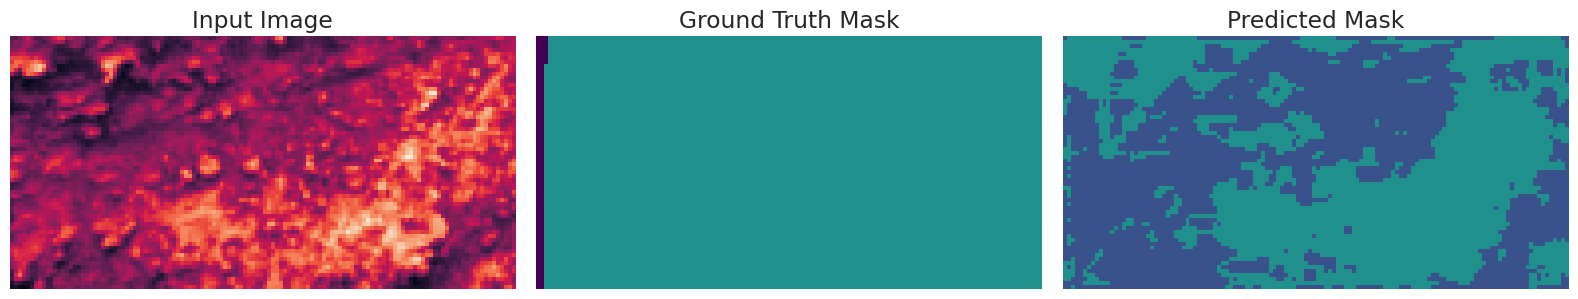

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0170 - mean_iou: 0.6586 - val_loss: 0.0424 - val_mean_iou: 0.5922 - learning_rate: 5.0000e-04
Epoch 92/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0158 - mean_iou: 0.6666 - val_loss: 0.0489 - val_mean_iou: 0.5954 - learning_rate: 5.0000e-04
Epoch 93/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0156 - mean_iou: 0.6756 - val_loss: 0.0485 - val_mean_iou: 0.6030 - learning_rate: 5.0000e-04
Epoch 94/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0151 - mean_iou: 0.6773 - val_loss: 0.0459 - val_mean_iou: 0.5939 - learning_rate: 5.0000e-04
Epoch 95/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0161 - mean_iou: 0.6568 - val_loss: 0.0533 - val_mean_iou: 0.6031 - learning_rate: 5.0000e-04
Epoch 96/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0151 - mean_iou: 0.6826

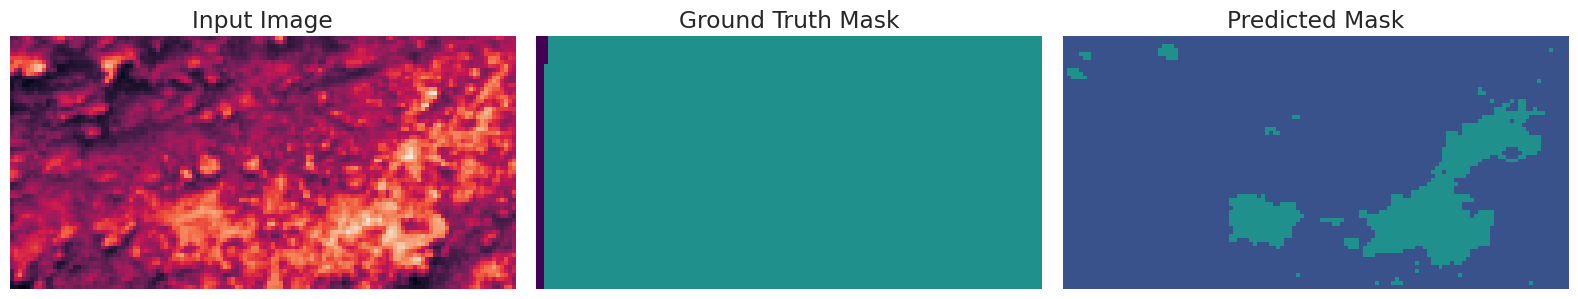

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0151 - mean_iou: 0.6826 - val_loss: 0.0548 - val_mean_iou: 0.6043 - learning_rate: 5.0000e-04
Epoch 97/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0144 - mean_iou: 0.6903 - val_loss: 0.0464 - val_mean_iou: 0.6009 - learning_rate: 5.0000e-04
Epoch 98/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0145 - mean_iou: 0.6822 - val_loss: 0.0438 - val_mean_iou: 0.5944 - learning_rate: 5.0000e-04
Epoch 99/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0199 - mean_iou: 0.6221 - val_loss: 0.0542 - val_mean_iou: 0.6125 - learning_rate: 5.0000e-04
Epoch 100/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0144 - mean_iou: 0.6872 - val_loss: 0.0482 - val_mean_iou: 0.5911 - learning_rate: 5.0000e-04
Epoch 101/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0196 - mean_iou: 0.6416

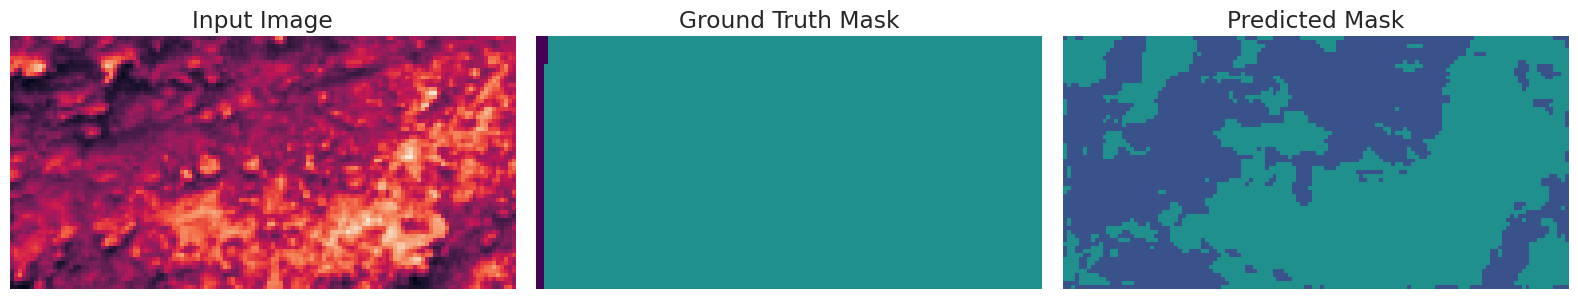

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0196 - mean_iou: 0.6416 - val_loss: 0.0399 - val_mean_iou: 0.5943 - learning_rate: 5.0000e-04
Epoch 102/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0166 - mean_iou: 0.6556 - val_loss: 0.0507 - val_mean_iou: 0.5401 - learning_rate: 5.0000e-04
Epoch 103/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0221 - mean_iou: 0.6145 - val_loss: 0.0387 - val_mean_iou: 0.6011 - learning_rate: 5.0000e-04
Epoch 104/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0143 - mean_iou: 0.6873 - val_loss: 0.0506 - val_mean_iou: 0.6035 - learning_rate: 5.0000e-04
Epoch 105/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0132 - mean_iou: 0.7037 - val_loss: 0.0514 - val_mean_iou: 0.6100 - learning_rate: 5.0000e-04
Epoch 106/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0130 - mean_iou: 0.7058

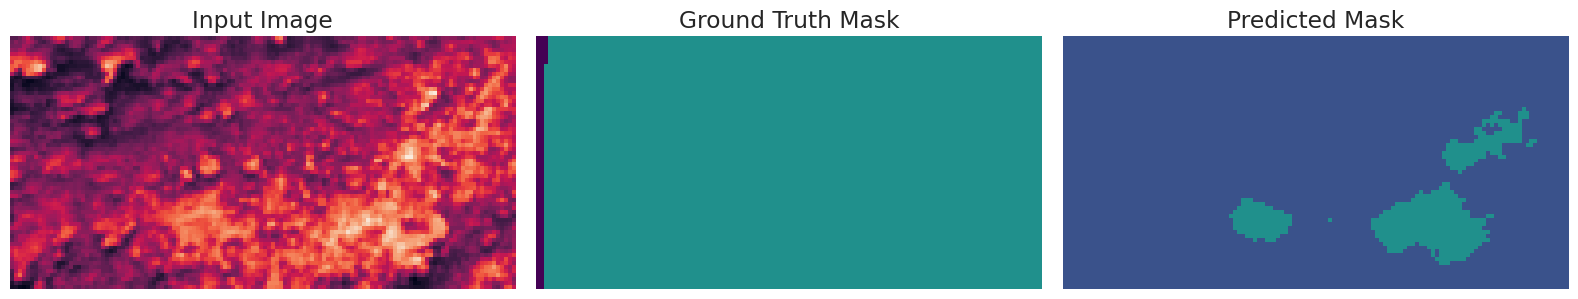

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0130 - mean_iou: 0.7059 - val_loss: 0.0543 - val_mean_iou: 0.6049 - learning_rate: 5.0000e-04
Epoch 107/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0127 - mean_iou: 0.7119 - val_loss: 0.0473 - val_mean_iou: 0.6026 - learning_rate: 5.0000e-04
Epoch 108/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0124 - mean_iou: 0.7077 - val_loss: 0.0426 - val_mean_iou: 0.6075 - learning_rate: 5.0000e-04
Epoch 109/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0122 - mean_iou: 0.7175
Epoch 109: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0122 - mean_iou: 0.7174 - val_loss: 0.0423 - val_mean_iou: 0.5437 - learning_rate: 5.0000e-04
Epoch 110/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0207 - mean_iou: 0.6279 - val_loss: 0.0518 - val_mean_iou: 0.6111 - learning_rate: 2.5000e-04
Epoch 111/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

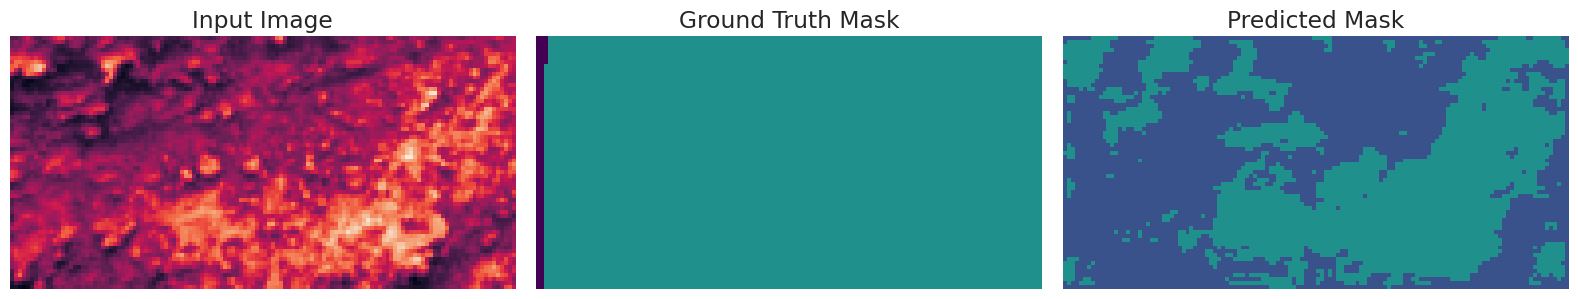

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0120 - mean_iou: 0.6964 - val_loss: 0.0537 - val_mean_iou: 0.6176 - learning_rate: 2.5000e-04
Epoch 112/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0111 - mean_iou: 0.7224 - val_loss: 0.0487 - val_mean_iou: 0.6134 - learning_rate: 2.5000e-04
Epoch 113/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0108 - mean_iou: 0.7294 - val_loss: 0.0514 - val_mean_iou: 0.6157 - learning_rate: 2.5000e-04
Epoch 114/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0107 - mean_iou: 0.7291 - val_loss: 0.0529 - val_mean_iou: 0.6193 - learning_rate: 2.5000e-04
Epoch 115/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0101 - mean_iou: 0.7377 - val_loss: 0.0547 - val_mean_iou: 0.6202 - learning_rate: 2.5000e-04
Epoch 116/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0098 - mean_iou: 0.7482

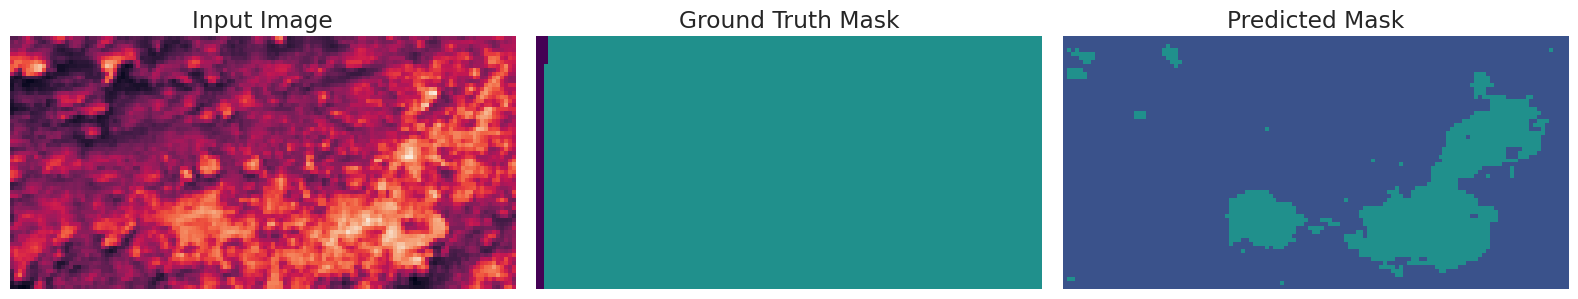

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0098 - mean_iou: 0.7483 - val_loss: 0.0535 - val_mean_iou: 0.6174 - learning_rate: 2.5000e-04
Epoch 117/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0097 - mean_iou: 0.7455 - val_loss: 0.0496 - val_mean_iou: 0.6091 - learning_rate: 2.5000e-04
Epoch 118/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0104 - mean_iou: 0.7308 - val_loss: 0.0558 - val_mean_iou: 0.6159 - learning_rate: 2.5000e-04
Epoch 119/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0095 - mean_iou: 0.7523 - val_loss: 0.0572 - val_mean_iou: 0.6199 - learning_rate: 2.5000e-04
Epoch 120/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0091 - mean_iou: 0.7563 - val_loss: 0.0575 - val_mean_iou: 0.6131 - learning_rate: 2.5000e-04
Epoch 121/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0091 - mean_iou: 0.7527

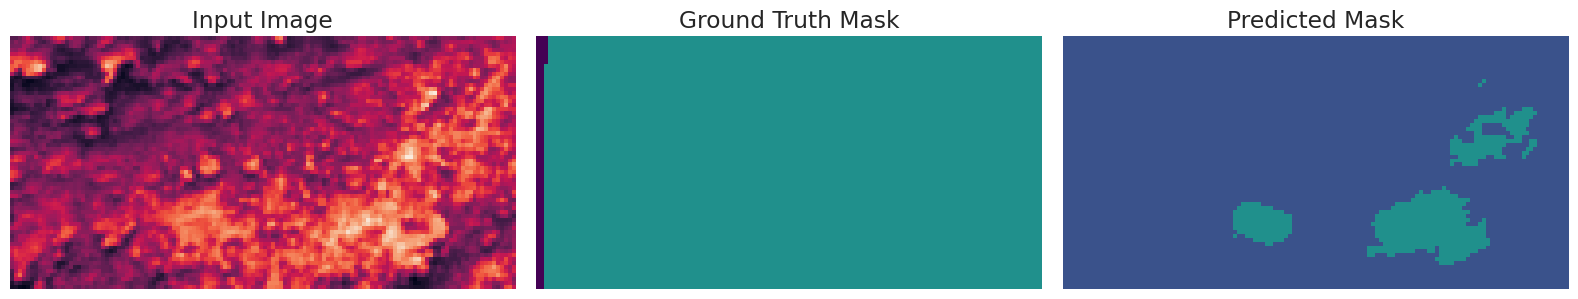

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0091 - mean_iou: 0.7529 - val_loss: 0.0605 - val_mean_iou: 0.6130 - learning_rate: 2.5000e-04
Epoch 122/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0093 - mean_iou: 0.7528 - val_loss: 0.0640 - val_mean_iou: 0.6169 - learning_rate: 2.5000e-04
Epoch 123/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0088 - mean_iou: 0.7586 - val_loss: 0.0639 - val_mean_iou: 0.6145 - learning_rate: 2.5000e-04
Epoch 124/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0089 - mean_iou: 0.7565 - val_loss: 0.0608 - val_mean_iou: 0.6198 - learning_rate: 2.5000e-04
Epoch 125/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0082 - mean_iou: 0.7721 - val_loss: 0.0610 - val_mean_iou: 0.6219 - learning_rate: 2.5000e-04
Epoch 126/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0096 - mean_iou: 0.7415

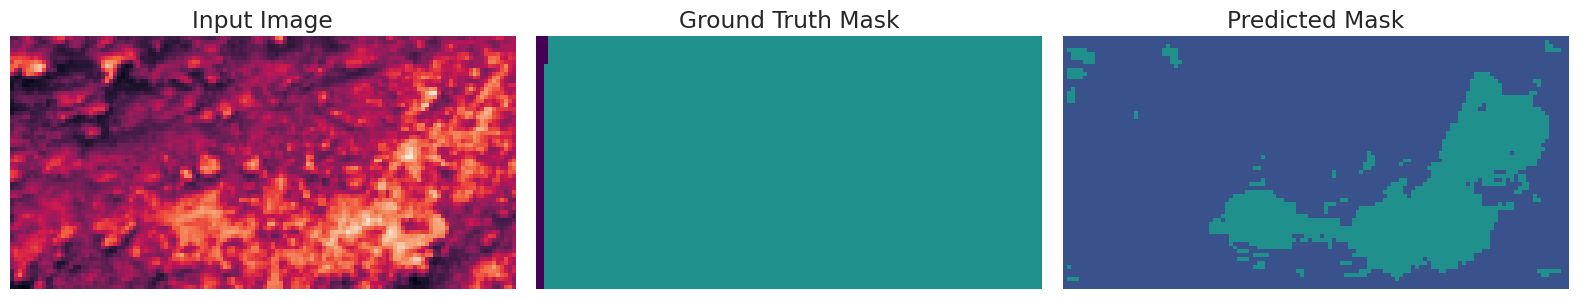

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0096 - mean_iou: 0.7415 - val_loss: 0.0658 - val_mean_iou: 0.6150 - learning_rate: 2.5000e-04
Epoch 127/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0085 - mean_iou: 0.7652 - val_loss: 0.0597 - val_mean_iou: 0.6184 - learning_rate: 2.5000e-04
Epoch 128/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0086 - mean_iou: 0.7555 - val_loss: 0.0626 - val_mean_iou: 0.6220 - learning_rate: 2.5000e-04
Epoch 129/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0081 - mean_iou: 0.7665 - val_loss: 0.0582 - val_mean_iou: 0.6100 - learning_rate: 2.5000e-04
Epoch 130/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0080 - mean_iou: 0.7727 - val_loss: 0.0591 - val_mean_iou: 0.6248 - learning_rate: 2.5000e-04
Epoch 131/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0076 - mean_iou: 0.7741

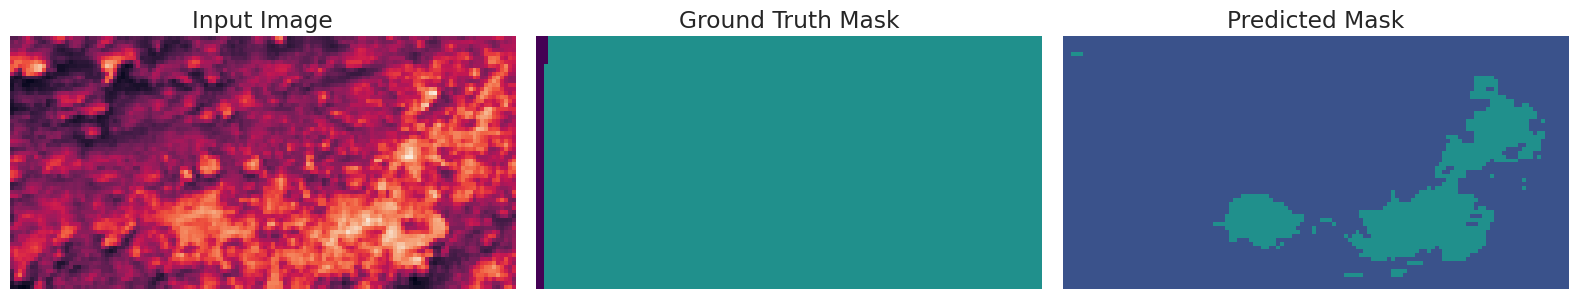

129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0076 - mean_iou: 0.7743 - val_loss: 0.0708 - val_mean_iou: 0.6344 - learning_rate: 2.5000e-04
Epoch 132/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0085 - mean_iou: 0.7628 - val_loss: 0.0511 - val_mean_iou: 0.5990 - learning_rate: 2.5000e-04
Epoch 133/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0090 - mean_iou: 0.7472 - val_loss: 0.0686 - val_mean_iou: 0.6093 - learning_rate: 2.5000e-04
Epoch 134/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0080 - mean_iou: 0.7659 - val_loss: 0.0553 - val_mean_iou: 0.6190 - learning_rate: 2.5000e-04
Epoch 135/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0075 - mean_iou: 0.7772 - val_loss: 0.0623 - val_mean_iou: 0.6248 - learning_rate: 2.5000e-04
Epoch 136/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0077 - mean_iou: 0.7717

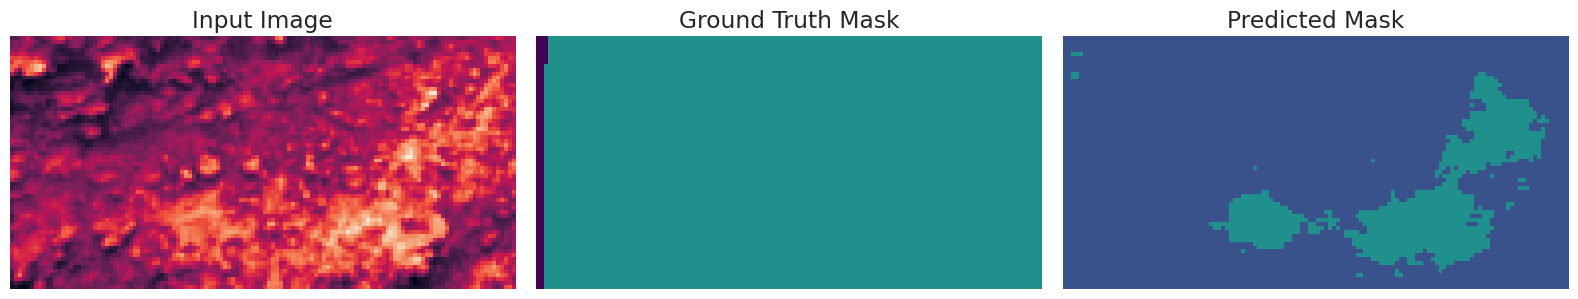

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0077 - mean_iou: 0.7719 - val_loss: 0.0708 - val_mean_iou: 0.6289 - learning_rate: 2.5000e-04
Epoch 137/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0071 - mean_iou: 0.7840 - val_loss: 0.0726 - val_mean_iou: 0.6351 - learning_rate: 2.5000e-04
Epoch 138/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0068 - mean_iou: 0.8026 - val_loss: 0.0747 - val_mean_iou: 0.6306 - learning_rate: 2.5000e-04
Epoch 139/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0066 - mean_iou: 0.8029 - val_loss: 0.0625 - val_mean_iou: 0.6297 - learning_rate: 2.5000e-04
Epoch 140/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0070 - mean_iou: 0.7872 - val_loss: 0.0626 - val_mean_iou: 0.6168 - learning_rate: 2.5000e-04
Epoch 141/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0073 - mean_iou: 0.7816

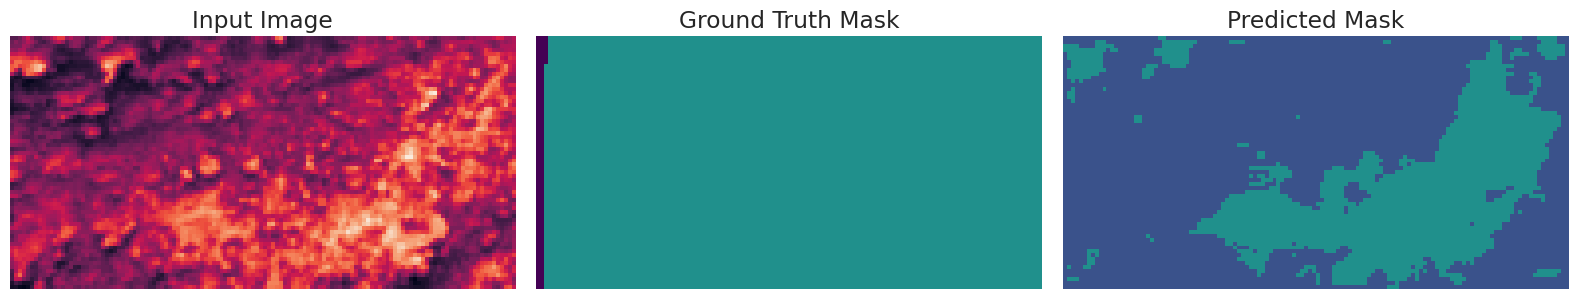

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0073 - mean_iou: 0.7818 - val_loss: 0.0750 - val_mean_iou: 0.6338 - learning_rate: 2.5000e-04
Epoch 142/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0067 - mean_iou: 0.8061 - val_loss: 0.0800 - val_mean_iou: 0.6231 - learning_rate: 2.5000e-04
Epoch 143/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0075 - mean_iou: 0.7880 - val_loss: 0.0641 - val_mean_iou: 0.6216 - learning_rate: 2.5000e-04
Epoch 144/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0065 - mean_iou: 0.8015 - val_loss: 0.0795 - val_mean_iou: 0.6204 - learning_rate: 2.5000e-04
Epoch 145/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0076 - mean_iou: 0.7873 - val_loss: 0.0782 - val_mean_iou: 0.6140 - learning_rate: 2.5000e-04
Epoch 146/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0069 - mean_iou: 0.7961

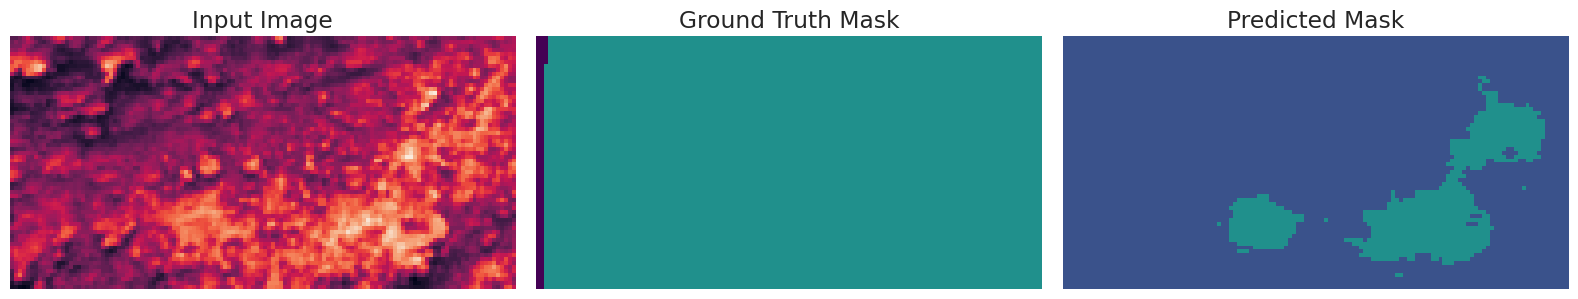

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0069 - mean_iou: 0.7960 - val_loss: 0.0640 - val_mean_iou: 0.6088 - learning_rate: 2.5000e-04
Epoch 147/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0065 - mean_iou: 0.7998
Epoch 147: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0065 - mean_iou: 0.7999 - val_loss: 0.0621 - val_mean_iou: 0.6228 - learning_rate: 2.5000e-04
Epoch 148/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0061 - mean_iou: 0.8069 - val_loss: 0.0740 - val_mean_iou: 0.6225 - learning_rate: 1.2500e-04
Epoch 149/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0059 - mean_iou: 0.8139 - val_loss: 0.0791 - val_mean_iou: 0.6253 - learning_rate: 1.2500e-04
Epoch 150/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0057 - mean_iou: 0.8133 - val_loss: 0.0836 - val_mean_iou: 0.6280 - learning_rate: 1.2500e-04
Epoch 151/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

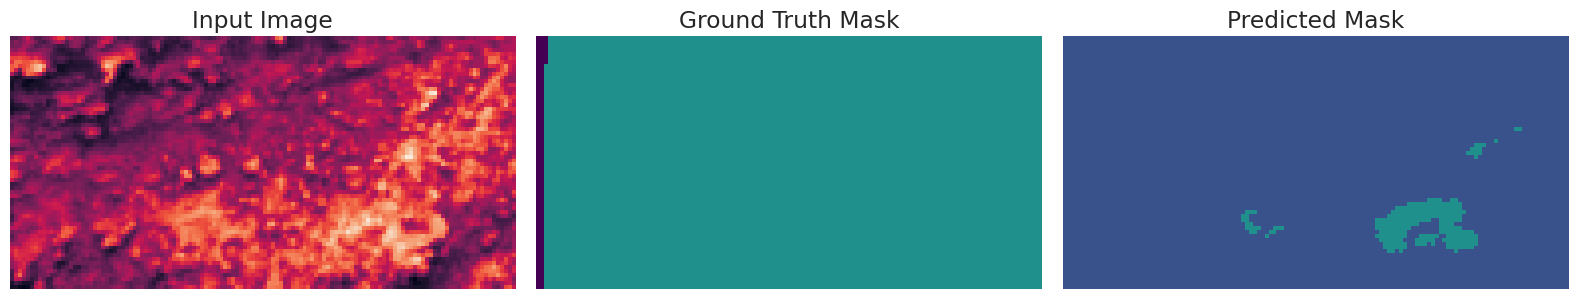

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0056 - mean_iou: 0.8234 - val_loss: 0.0801 - val_mean_iou: 0.6265 - learning_rate: 1.2500e-04
Epoch 152/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0055 - mean_iou: 0.8268 - val_loss: 0.0787 - val_mean_iou: 0.6254 - learning_rate: 1.2500e-04
Epoch 153/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0055 - mean_iou: 0.8262 - val_loss: 0.0771 - val_mean_iou: 0.6296 - learning_rate: 1.2500e-04
Epoch 154/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0054 - mean_iou: 0.8293 - val_loss: 0.0750 - val_mean_iou: 0.6268 - learning_rate: 1.2500e-04
Epoch 155/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0053 - mean_iou: 0.8281 - val_loss: 0.0763 - val_mean_iou: 0.6263 - learning_rate: 1.2500e-04
Epoch 156/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0053 - mean_iou: 0.8320

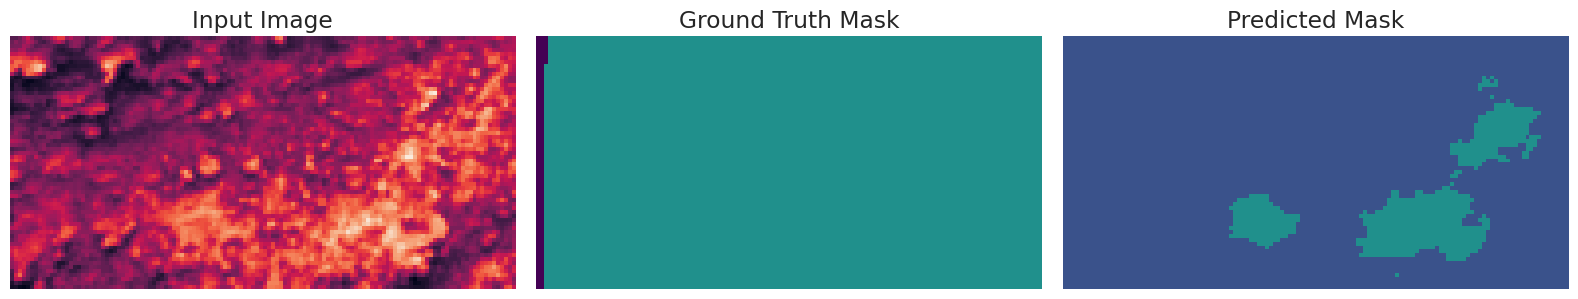

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0053 - mean_iou: 0.8322 - val_loss: 0.0789 - val_mean_iou: 0.6324 - learning_rate: 1.2500e-04
Epoch 157/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0052 - mean_iou: 0.8336
Epoch 157: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0052 - mean_iou: 0.8338 - val_loss: 0.0758 - val_mean_iou: 0.6214 - learning_rate: 1.2500e-04
Epoch 158/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0051 - mean_iou: 0.8288 - val_loss: 0.0819 - val_mean_iou: 0.6348 - learning_rate: 6.2500e-05
Epoch 159/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0050 - mean_iou: 0.8408 - val_loss: 0.0810 - val_mean_iou: 0.6342 - learning_rate: 6.2500e-05
Epoch 160/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0049 - mean_iou: 0.8379 - val_loss: 0.0824 - val_mean_iou: 0.6353 - learning_rate: 6.2500e-05
Epoch 161/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 

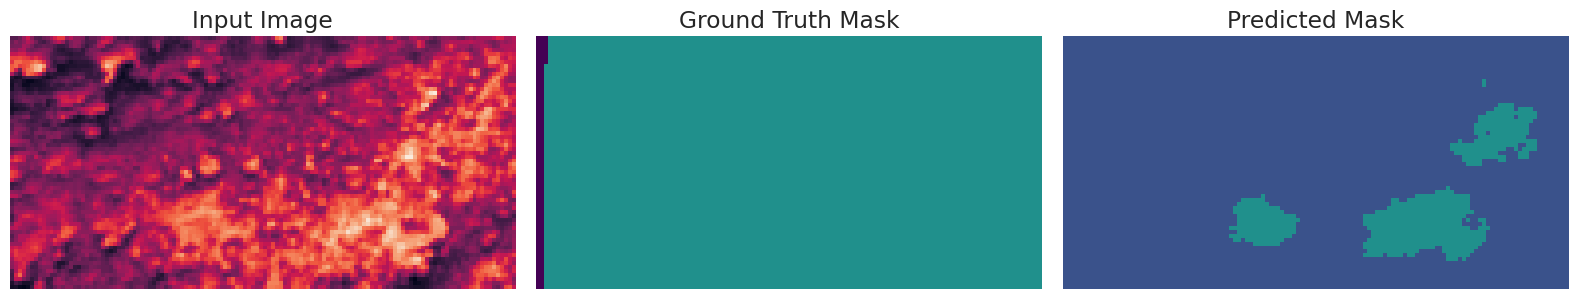

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0048 - mean_iou: 0.8419 - val_loss: 0.0813 - val_mean_iou: 0.6343 - learning_rate: 6.2500e-05
Epoch 162/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0048 - mean_iou: 0.8456 - val_loss: 0.0852 - val_mean_iou: 0.6363 - learning_rate: 6.2500e-05
Epoch 163/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0048 - mean_iou: 0.8449 - val_loss: 0.0828 - val_mean_iou: 0.6337 - learning_rate: 6.2500e-05
Epoch 164/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0047 - mean_iou: 0.8440 - val_loss: 0.0847 - val_mean_iou: 0.6350 - learning_rate: 6.2500e-05
Epoch 165/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0047 - mean_iou: 0.8469 - val_loss: 0.0819 - val_mean_iou: 0.6341 - learning_rate: 6.2500e-05
Epoch 166/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0046 - mean_iou: 0.8503

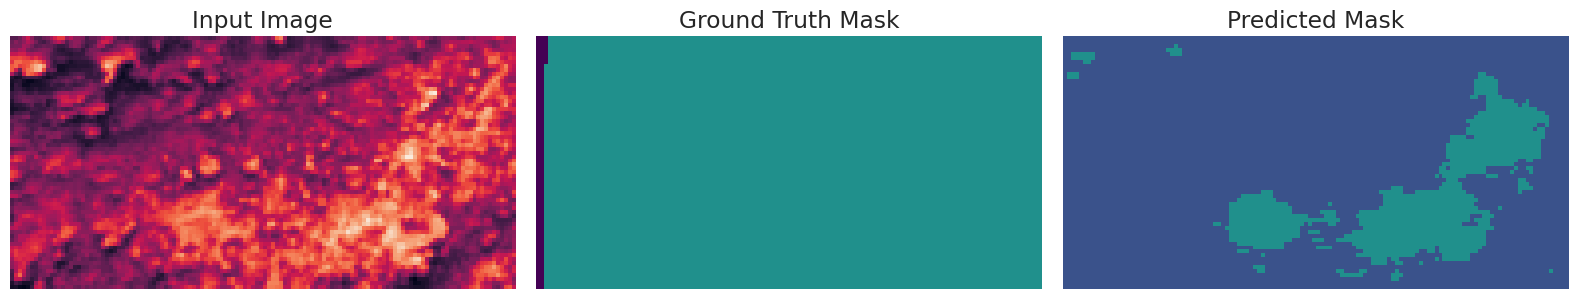

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0046 - mean_iou: 0.8504 - val_loss: 0.0845 - val_mean_iou: 0.6346 - learning_rate: 6.2500e-05
Epoch 167/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0046 - mean_iou: 0.8502 - val_loss: 0.0872 - val_mean_iou: 0.6345 - learning_rate: 6.2500e-05
Epoch 168/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0046 - mean_iou: 0.8476 - val_loss: 0.0805 - val_mean_iou: 0.6332 - learning_rate: 6.2500e-05
Epoch 169/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0046 - mean_iou: 0.8515 - val_loss: 0.0857 - val_mean_iou: 0.6359 - learning_rate: 6.2500e-05
Epoch 170/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0046 - mean_iou: 0.8533 - val_loss: 0.0866 - val_mean_iou: 0.6336 - learning_rate: 6.2500e-05
Epoch 171/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0045 - mean_iou: 0.8559

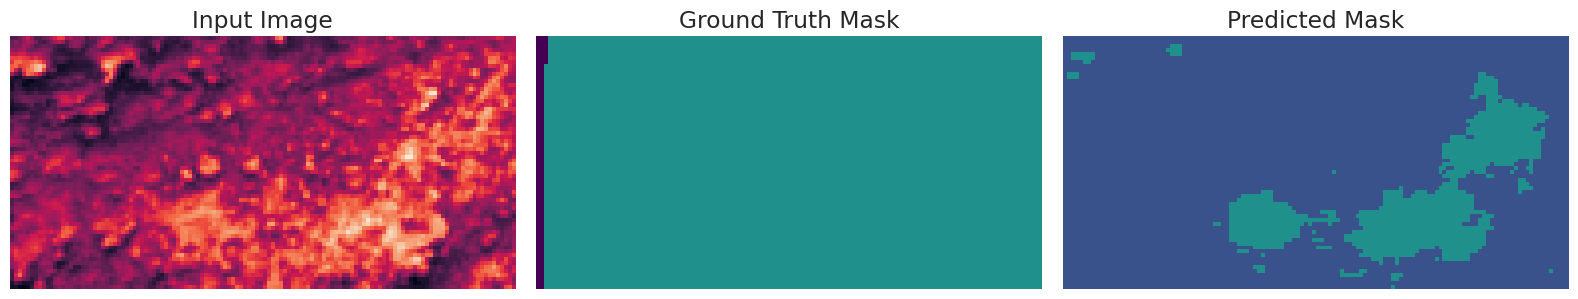

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0045 - mean_iou: 0.8559 - val_loss: 0.0863 - val_mean_iou: 0.6348 - learning_rate: 6.2500e-05
Epoch 172/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0045 - mean_iou: 0.8530
Epoch 172: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0045 - mean_iou: 0.8531 - val_loss: 0.0851 - val_mean_iou: 0.6352 - learning_rate: 6.2500e-05
Epoch 173/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0046 - mean_iou: 0.8498 - val_loss: 0.0910 - val_mean_iou: 0.6356 - learning_rate: 3.1250e-05
Epoch 174/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0044 - mean_iou: 0.8582 - val_loss: 0.0919 - val_mean_iou: 0.6371 - learning_rate: 3.1250e-05
Epoch 175/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0043 - mean_iou: 0.8611 - val_loss: 0.0921 - val_mean_iou: 0.6377 - learning_rate: 3.1250e-05
Epoch 176/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

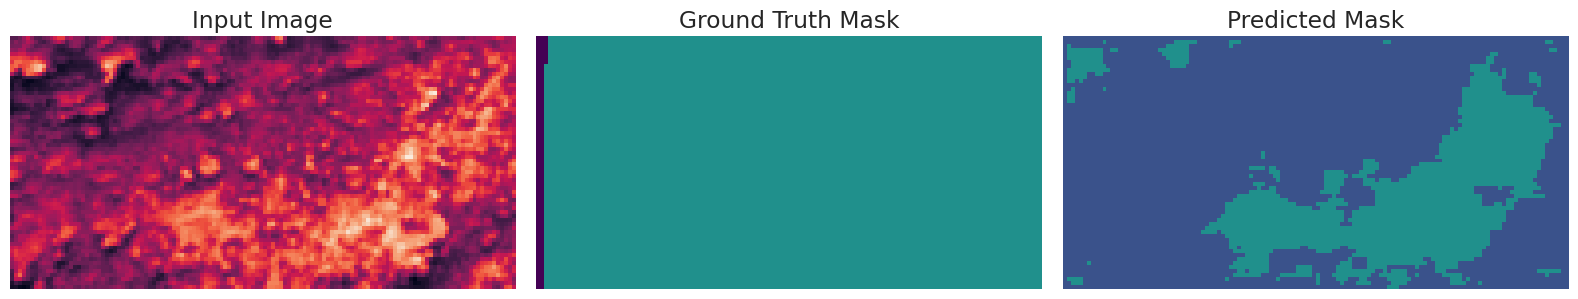

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0044 - mean_iou: 0.8564 - val_loss: 0.0931 - val_mean_iou: 0.6384 - learning_rate: 3.1250e-05
Epoch 177/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0044 - mean_iou: 0.8628 - val_loss: 0.0929 - val_mean_iou: 0.6381 - learning_rate: 3.1250e-05
Epoch 178/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0043 - mean_iou: 0.8639 - val_loss: 0.0921 - val_mean_iou: 0.6376 - learning_rate: 3.1250e-05
Epoch 179/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0043 - mean_iou: 0.8642 - val_loss: 0.0919 - val_mean_iou: 0.6369 - learning_rate: 3.1250e-05
Epoch 180/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0043 - mean_iou: 0.8651 - val_loss: 0.0917 - val_mean_iou: 0.6386 - learning_rate: 3.1250e-05
Epoch 181/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0043 - mean_iou: 0.8637

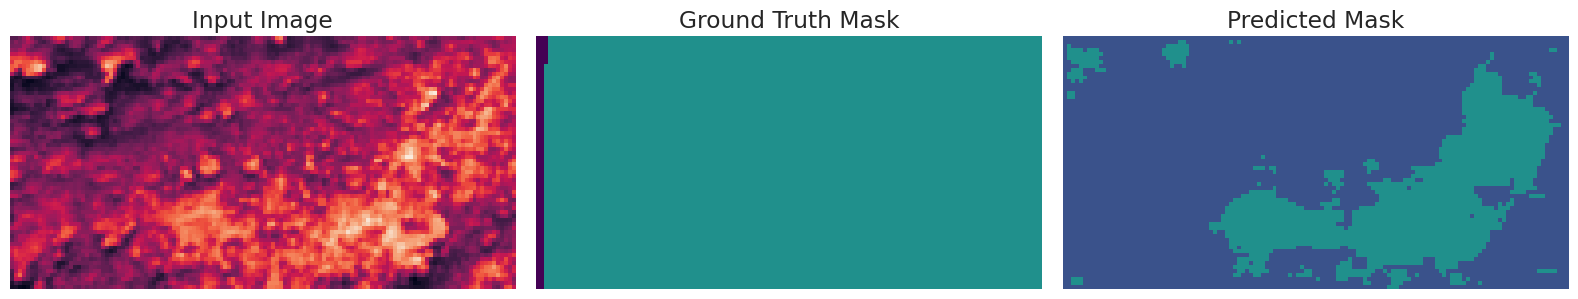

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0043 - mean_iou: 0.8637 - val_loss: 0.0920 - val_mean_iou: 0.6379 - learning_rate: 3.1250e-05
Epoch 182/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0042 - mean_iou: 0.8668 - val_loss: 0.0929 - val_mean_iou: 0.6380 - learning_rate: 3.1250e-05
Epoch 183/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0042 - mean_iou: 0.8655 - val_loss: 0.0951 - val_mean_iou: 0.6380 - learning_rate: 3.1250e-05
Epoch 184/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0042 - mean_iou: 0.8640 - val_loss: 0.0949 - val_mean_iou: 0.6386 - learning_rate: 3.1250e-05
Epoch 185/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0042 - mean_iou: 0.8690 - val_loss: 0.0947 - val_mean_iou: 0.6387 - learning_rate: 3.1250e-05
Epoch 186/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0042 - mean_iou: 0.8683

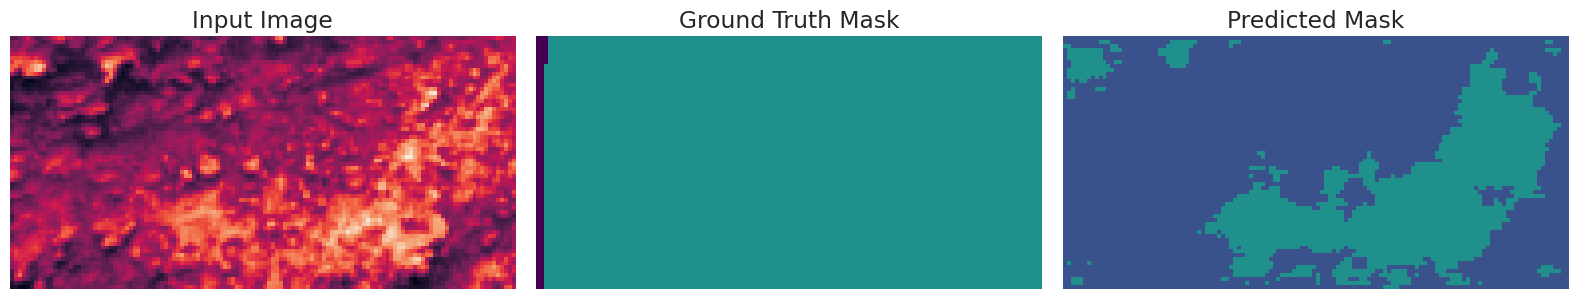

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0042 - mean_iou: 0.8683 - val_loss: 0.0955 - val_mean_iou: 0.6386 - learning_rate: 3.1250e-05
Epoch 187/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0041 - mean_iou: 0.8698 - val_loss: 0.0962 - val_mean_iou: 0.6376 - learning_rate: 3.1250e-05
Epoch 188/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0042 - mean_iou: 0.8737 - val_loss: 0.0920 - val_mean_iou: 0.6372 - learning_rate: 3.1250e-05
Epoch 189/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0041 - mean_iou: 0.8685 - val_loss: 0.0930 - val_mean_iou: 0.6376 - learning_rate: 3.1250e-05
Epoch 190/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0040 - mean_iou: 0.8730 - val_loss: 0.0940 - val_mean_iou: 0.6390 - learning_rate: 3.1250e-05
Epoch 191/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0041 - mean_iou: 0.8719

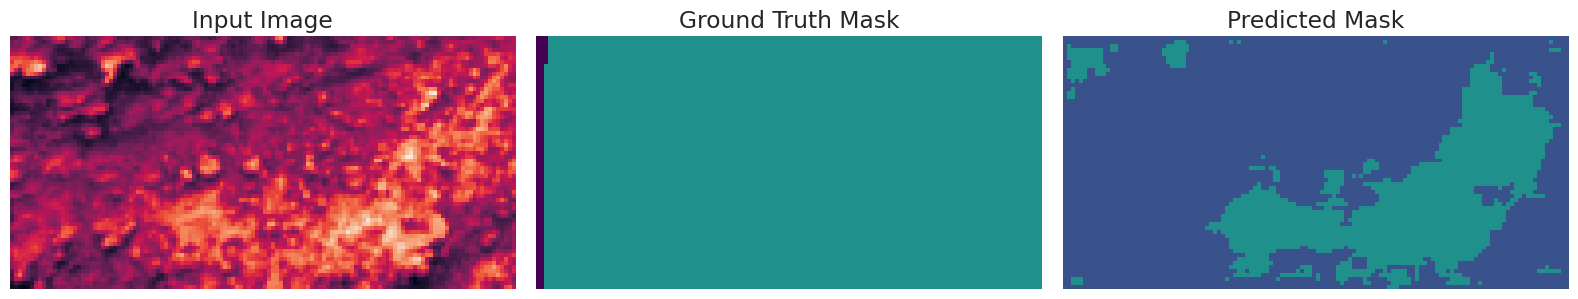

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0041 - mean_iou: 0.8719 - val_loss: 0.0956 - val_mean_iou: 0.6382 - learning_rate: 3.1250e-05
Epoch 192/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0041 - mean_iou: 0.8723 - val_loss: 0.0941 - val_mean_iou: 0.6385 - learning_rate: 3.1250e-05
Epoch 193/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0041 - mean_iou: 0.8694 - val_loss: 0.0948 - val_mean_iou: 0.6386 - learning_rate: 3.1250e-05
Epoch 194/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0041 - mean_iou: 0.8708 - val_loss: 0.0969 - val_mean_iou: 0.6386 - learning_rate: 3.1250e-05
Epoch 195/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0040 - mean_iou: 0.8740 - val_loss: 0.0975 - val_mean_iou: 0.6382 - learning_rate: 3.1250e-05
Epoch 196/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0040 - mean_iou: 0.8699

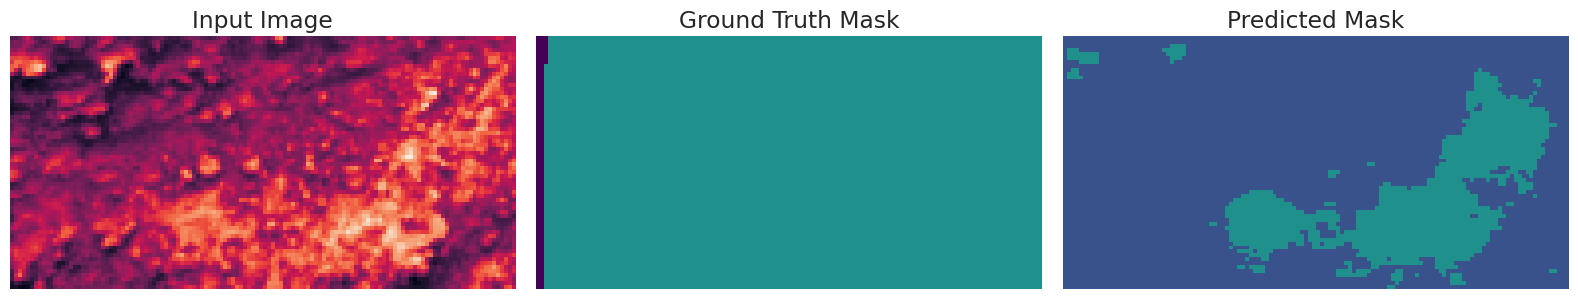

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0040 - mean_iou: 0.8699 - val_loss: 0.0974 - val_mean_iou: 0.6374 - learning_rate: 3.1250e-05
Epoch 197/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0040 - mean_iou: 0.8760 - val_loss: 0.0980 - val_mean_iou: 0.6376 - learning_rate: 3.1250e-05
Epoch 198/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0040 - mean_iou: 0.8731 - val_loss: 0.0977 - val_mean_iou: 0.6398 - learning_rate: 3.1250e-05
Epoch 199/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0040 - mean_iou: 0.8736 - val_loss: 0.0952 - val_mean_iou: 0.6370 - learning_rate: 3.1250e-05
Epoch 200/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0040 - mean_iou: 0.8743 - val_loss: 0.0967 - val_mean_iou: 0.6398 - learning_rate: 3.1250e-05
Epoch 201/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0040 - mean_iou: 0.8756

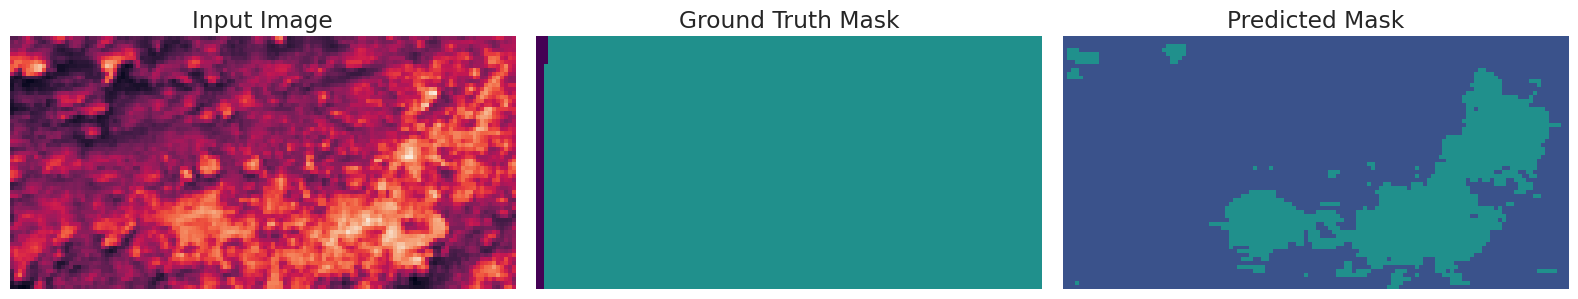

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0040 - mean_iou: 0.8756 - val_loss: 0.0986 - val_mean_iou: 0.6383 - learning_rate: 3.1250e-05
Epoch 202/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0040 - mean_iou: 0.8737 - val_loss: 0.0975 - val_mean_iou: 0.6385 - learning_rate: 3.1250e-05
Epoch 203/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0040 - mean_iou: 0.8777 - val_loss: 0.1018 - val_mean_iou: 0.6382 - learning_rate: 3.1250e-05
Epoch 204/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0040 - mean_iou: 0.8763 - val_loss: 0.1020 - val_mean_iou: 0.6370 - learning_rate: 3.1250e-05
Epoch 205/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0039 - mean_iou: 0.8778 - val_loss: 0.1001 - val_mean_iou: 0.6385 - learning_rate: 3.1250e-05
Epoch 206/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0039 - mean_iou: 0.8771

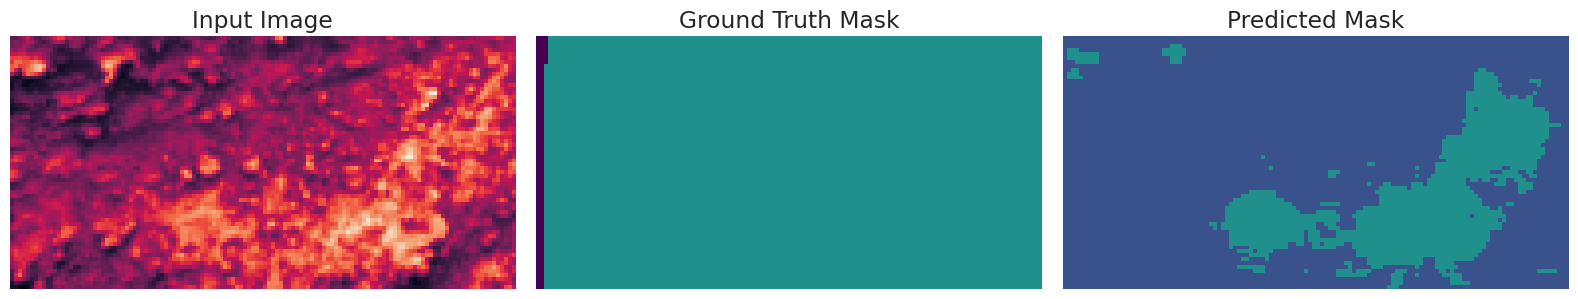

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0039 - mean_iou: 0.8771 - val_loss: 0.1012 - val_mean_iou: 0.6381 - learning_rate: 3.1250e-05
Epoch 207/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0039 - mean_iou: 0.8773 - val_loss: 0.1032 - val_mean_iou: 0.6367 - learning_rate: 3.1250e-05
Epoch 208/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0039 - mean_iou: 0.8806
Epoch 208: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0039 - mean_iou: 0.8806 - val_loss: 0.0994 - val_mean_iou: 0.6382 - learning_rate: 3.1250e-05
Epoch 209/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0038 - mean_iou: 0.8784 - val_loss: 0.1040 - val_mean_iou: 0.6374 - learning_rate: 1.5625e-05
Epoch 210/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0039 - mean_iou: 0.8810 - val_loss: 0.1047 - val_mean_iou: 0.6381 - learning_rate: 1.5625e-05
Epoch 211/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/ste

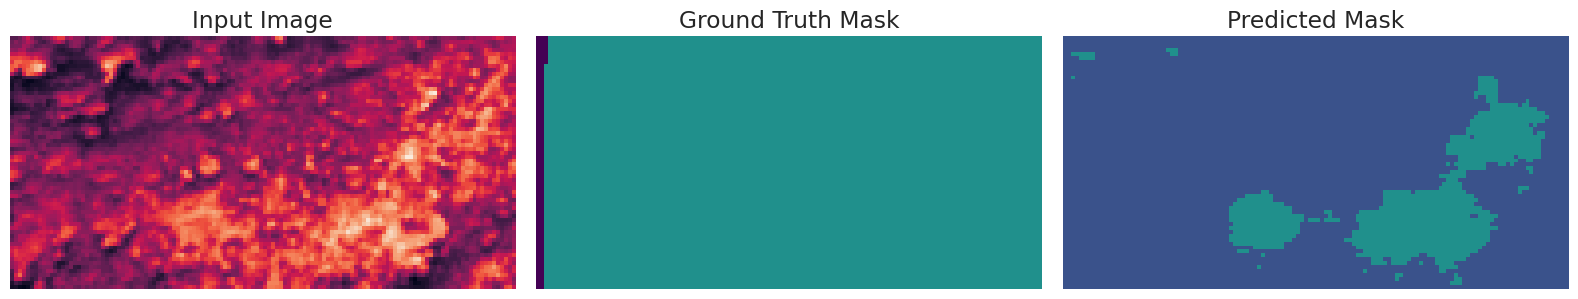

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0038 - mean_iou: 0.8821 - val_loss: 0.1050 - val_mean_iou: 0.6376 - learning_rate: 1.5625e-05
Epoch 212/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0038 - mean_iou: 0.8809 - val_loss: 0.1063 - val_mean_iou: 0.6376 - learning_rate: 1.5625e-05
Epoch 213/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0038 - mean_iou: 0.8864 - val_loss: 0.1073 - val_mean_iou: 0.6371 - learning_rate: 1.5625e-05
Epoch 214/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0038 - mean_iou: 0.8839 - val_loss: 0.1064 - val_mean_iou: 0.6371 - learning_rate: 1.5625e-05
Epoch 215/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0038 - mean_iou: 0.8865 - val_loss: 0.1070 - val_mean_iou: 0.6374 - learning_rate: 1.5625e-05
Epoch 216/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0038 - mean_iou: 0.8848

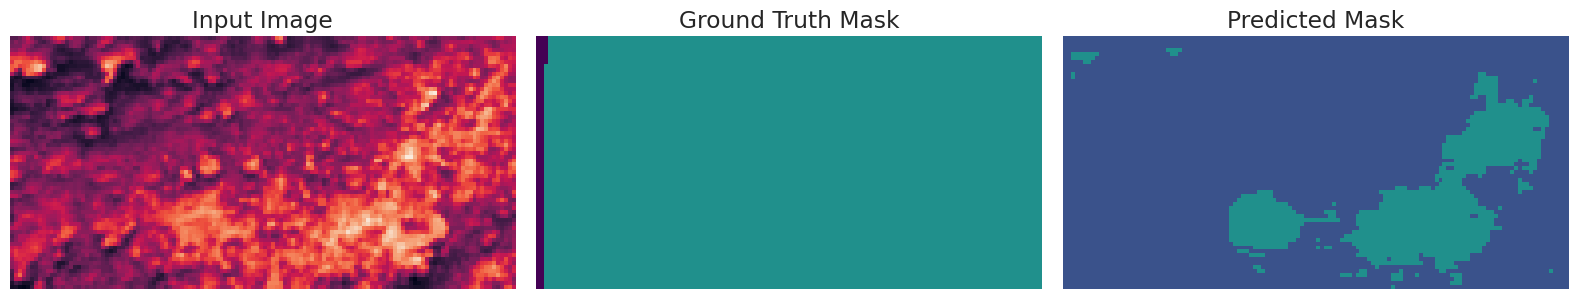

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0038 - mean_iou: 0.8848 - val_loss: 0.1068 - val_mean_iou: 0.6374 - learning_rate: 1.5625e-05
Epoch 217/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0037 - mean_iou: 0.8841 - val_loss: 0.1080 - val_mean_iou: 0.6365 - learning_rate: 1.5625e-05
Epoch 218/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0038 - mean_iou: 0.8849
Epoch 218: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0038 - mean_iou: 0.8848 - val_loss: 0.1067 - val_mean_iou: 0.6371 - learning_rate: 1.5625e-05
Epoch 219/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0038 - mean_iou: 0.8876 - val_loss: 0.1080 - val_mean_iou: 0.6352 - learning_rate: 7.8125e-06
Epoch 220/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0038 - mean_iou: 0.8863 - val_loss: 0.1076 - val_mean_iou: 0.6354 - learning_rate: 7.8125e-06
Epoch 221/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

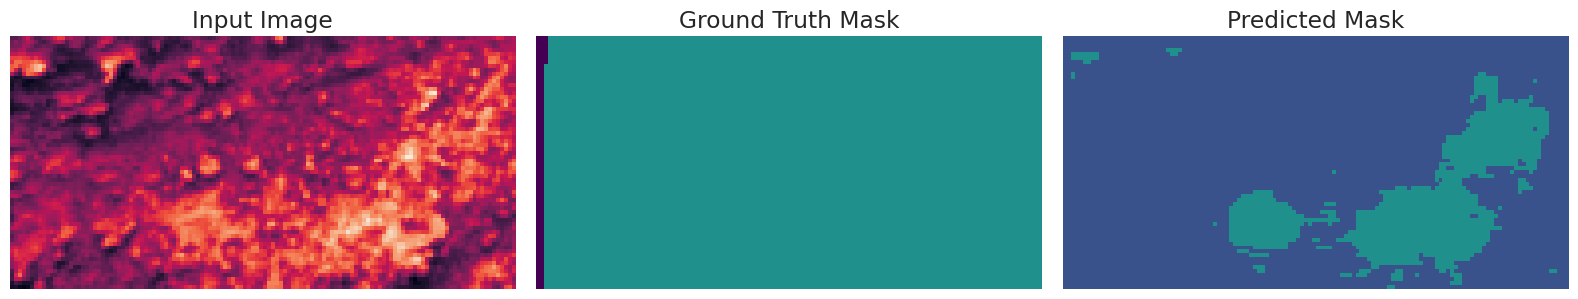

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0037 - mean_iou: 0.8881 - val_loss: 0.1076 - val_mean_iou: 0.6355 - learning_rate: 7.8125e-06
Epoch 222/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0037 - mean_iou: 0.8870 - val_loss: 0.1083 - val_mean_iou: 0.6352 - learning_rate: 7.8125e-06
Epoch 223/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0037 - mean_iou: 0.8893 - val_loss: 0.1080 - val_mean_iou: 0.6354 - learning_rate: 7.8125e-06
Epoch 224/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0037 - mean_iou: 0.8879 - val_loss: 0.1080 - val_mean_iou: 0.6355 - learning_rate: 7.8125e-06
Epoch 225/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0037 - mean_iou: 0.8875 - val_loss: 0.1082 - val_mean_iou: 0.6359 - learning_rate: 7.8125e-06
Epoch 226/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0037 - mean_iou: 0.8880

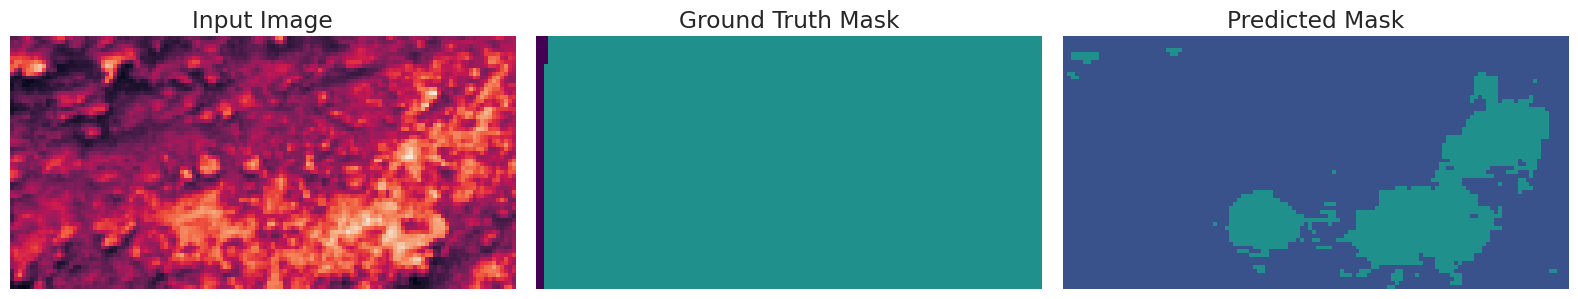

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0037 - mean_iou: 0.8880 - val_loss: 0.1081 - val_mean_iou: 0.6358 - learning_rate: 7.8125e-06
Epoch 227/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0037 - mean_iou: 0.8878 - val_loss: 0.1082 - val_mean_iou: 0.6358 - learning_rate: 7.8125e-06
Epoch 228/1000
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0037 - mean_iou: 0.8860
Epoch 228: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0037 - mean_iou: 0.8860 - val_loss: 0.1087 - val_mean_iou: 0.6357 - learning_rate: 7.8125e-06
Epoch 229/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0037 - mean_iou: 0.8901 - val_loss: 0.1072 - val_mean_iou: 0.6354 - learning_rate: 3.9063e-06
Epoch 230/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0037 - mean_iou: 0.8871 - val_loss: 0.1071 - val_mean_iou: 0.6353 - learning_rate: 3.9063e-06
Final validation Mean Intersection Over Union: 63.98%


In [23]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, lr_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

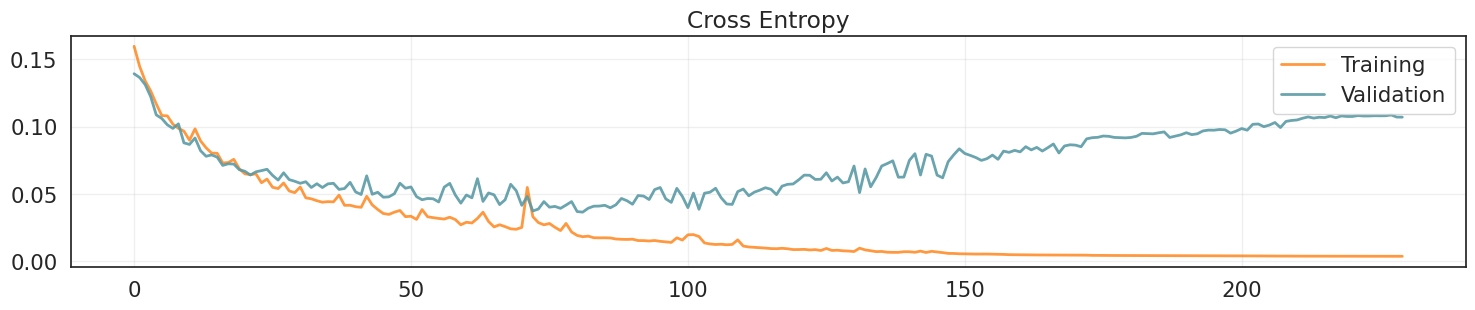

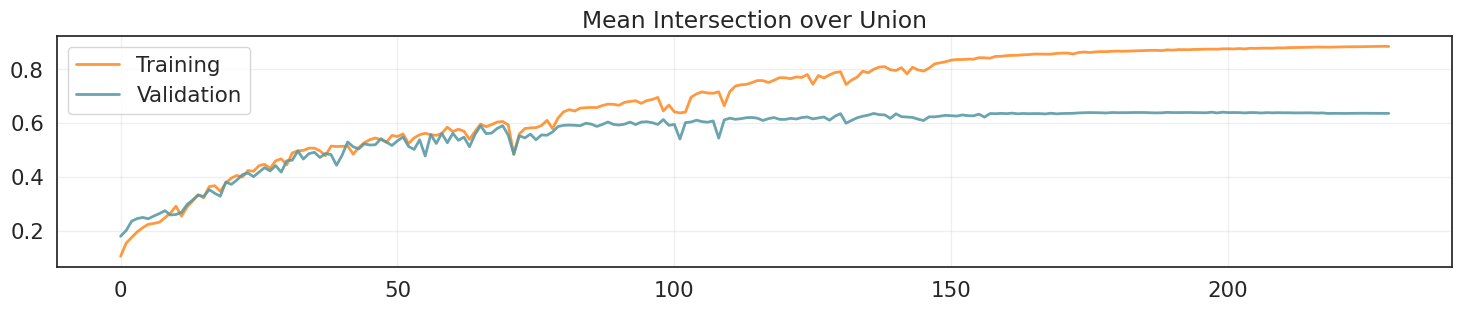

In [24]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [25]:
#Get prediction
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step
Predictions shape: (10022, 64, 128)


In [26]:
def y_to_df(y) -> pd.DataFrame:
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [27]:
submission_filename = f"CustomUNetFocalCw.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)